# Полный интерактивный отчёт по продажам

**50+ графиков с интерактивными фильтрами**

## Содержание:
1. Общая статистика (5 графиков)
2. Анализ покупателей (20 графиков)
3. Анализ групп товаров (15 графиков)
4. Связь покупателей и групп (10 графиков)
5. Экспорт в standalone HTML

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

# Список для сбора всех графиков
all_figures = []

In [5]:
# Загрузка данных
file_path = 'test_sales_data.xlsx'
df_raw = pd.read_excel(file_path, header=None)
print(f'Размер данных: {df_raw.shape}')

Размер данных: (1004, 3025)


In [6]:
# Парсинг шапки
years_row = df_raw.iloc[0, 1:].ffill().values
months_row = df_raw.iloc[1, 1:].ffill().values
groups_row = df_raw.iloc[2, 1:].ffill().values
metrics_row = df_raw.iloc[3, 1:].values

# Создание MultiIndex
columns = pd.MultiIndex.from_arrays(
    [years_row, months_row, groups_row, metrics_row],
    names=['Год', 'Месяц', 'Группа', 'Показатель']
)

# Данные клиентов
df = df_raw.iloc[4:].copy()
df.columns = ['client_id'] + list(range(len(df.columns) - 1))
df = df.set_index('client_id')
df.columns = columns

print(f'Клиентов: {len(df)}')

Клиентов: 1000


In [7]:
# Преобразование в long format
df_long = df.stack(level=['Год', 'Месяц', 'Группа']).reset_index()
df_long.columns.name = None

# Преобразование типов
numeric_cols = ['Количество в чеке', 'Сумма в чеке', 'Число чеков']
for col in numeric_cols:
    df_long[col] = pd.to_numeric(df_long[col], errors='coerce')

# Средняя цена товара
df_long['Средняя цена товара'] = df_long['Сумма в чеке'] / df_long['Количество в чеке']

# Порядок месяцев
months_order = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь',
               'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

print(f'Записей: {len(df_long)}')

Записей: 704911


In [8]:
# === ПОДГОТОВКА АГРЕГАТОВ ===

# Статистика по клиентам
client_stats = df_long.groupby('client_id').agg({
    'Сумма в чеке': 'sum',
    'Количество в чеке': 'sum',
    'Число чеков': 'sum',
    'Средняя цена товара': 'mean'
}).reset_index()
client_stats.columns = ['client_id', 'Всего сумма', 'Всего количество', 'Всего чеков', 'Средняя цена']
client_stats['Средний чек'] = client_stats['Всего сумма'] / client_stats['Всего чеков']

# Сегментация по сумме
q75 = client_stats['Всего сумма'].quantile(0.75)
q50 = client_stats['Всего сумма'].quantile(0.50)
q25 = client_stats['Всего сумма'].quantile(0.25)

def segment_by_sum(total):
    if total >= q75: return 'VIP'
    elif total >= q50: return 'Активный'
    elif total >= q25: return 'Средний'
    else: return 'Низкий'

client_stats['Сегмент'] = client_stats['Всего сумма'].apply(segment_by_sum)

# Сегментация по цене
q75_price = client_stats['Средняя цена'].quantile(0.75)
q50_price = client_stats['Средняя цена'].quantile(0.50)
q25_price = client_stats['Средняя цена'].quantile(0.25)

def segment_by_price(price):
    if price >= q75_price: return 'Премиум'
    elif price >= q50_price: return 'Средний+'
    elif price >= q25_price: return 'Средний'
    else: return 'Эконом'

client_stats['Ценовой сегмент'] = client_stats['Средняя цена'].apply(segment_by_price)

print('Агрегаты подготовлены')

Агрегаты подготовлены


---
# РАЗДЕЛ 1: Общая статистика (5 графиков)

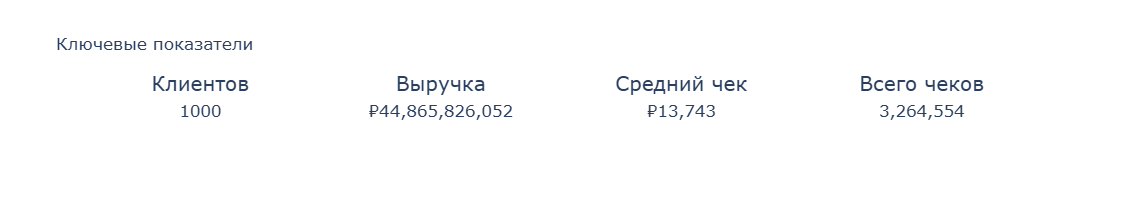

In [9]:
# График 1: KPI карточки
total_revenue = df_long['Сумма в чеке'].sum()
total_clients = df_long['client_id'].nunique()
total_checks = df_long['Число чеков'].sum()
avg_check = total_revenue / total_checks

fig1 = go.Figure()
fig1.add_trace(go.Indicator(
    mode="number",
    value=total_clients,
    title={"text": "Клиентов"},
    domain={'x': [0, 0.25], 'y': [0, 1]}
))
fig1.add_trace(go.Indicator(
    mode="number",
    value=total_revenue,
    title={"text": "Выручка"},
    number={'prefix': '₽', 'valueformat': ',.0f'},
    domain={'x': [0.25, 0.5], 'y': [0, 1]}
))
fig1.add_trace(go.Indicator(
    mode="number",
    value=avg_check,
    title={"text": "Средний чек"},
    number={'prefix': '₽', 'valueformat': ',.0f'},
    domain={'x': [0.5, 0.75], 'y': [0, 1]}
))
fig1.add_trace(go.Indicator(
    mode="number",
    value=total_checks,
    title={"text": "Всего чеков"},
    number={'valueformat': ',.0f'},
    domain={'x': [0.75, 1], 'y': [0, 1]}
))
fig1.update_layout(title='Ключевые показатели', height=200)
all_figures.append(('1. KPI', fig1))
fig1.show()

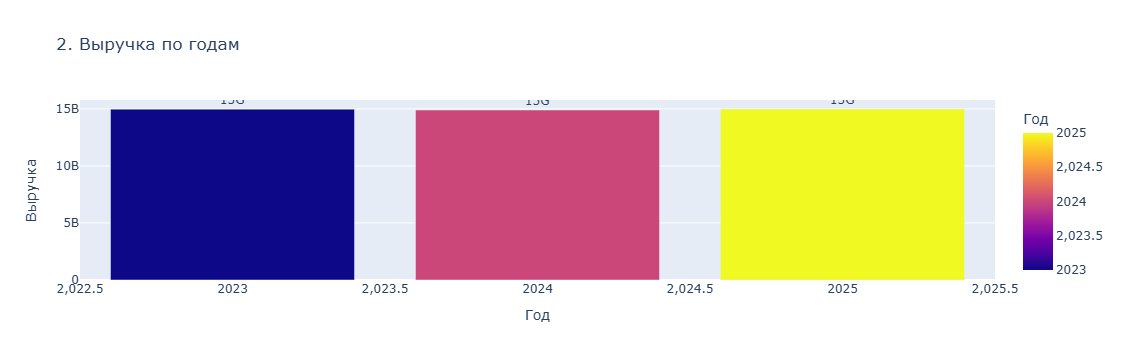

In [10]:
# График 2: Динамика выручки по годам
yearly_revenue = df_long.groupby('Год')['Сумма в чеке'].sum().reset_index()
yearly_revenue.columns = ['Год', 'Выручка']

fig2 = px.bar(yearly_revenue, x='Год', y='Выручка', 
              title='2. Выручка по годам',
              text_auto='.2s', color='Год')
fig2.update_traces(textposition='outside')
all_figures.append(('2. Выручка по годам', fig2))
fig2.show()

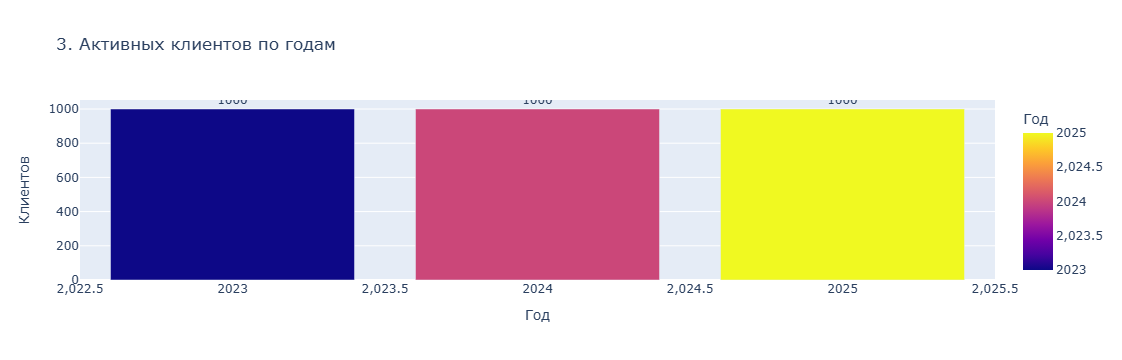

In [11]:
# График 3: Динамика клиентов по годам
yearly_clients = df_long.groupby('Год')['client_id'].nunique().reset_index()
yearly_clients.columns = ['Год', 'Клиентов']

fig3 = px.bar(yearly_clients, x='Год', y='Клиентов',
              title='3. Активных клиентов по годам',
              text_auto=True, color='Год')
fig3.update_traces(textposition='outside')
all_figures.append(('3. Клиенты по годам', fig3))
fig3.show()

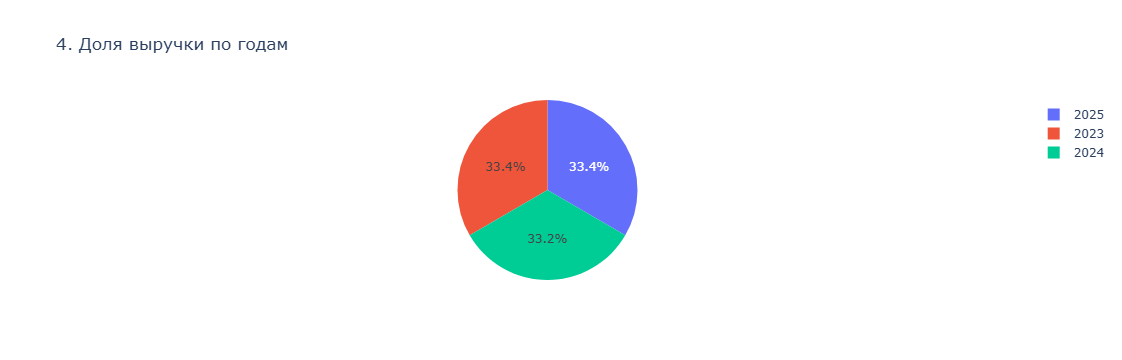

In [12]:
# График 4: Распределение выручки по годам (pie)
fig4 = px.pie(yearly_revenue, values='Выручка', names='Год',
              title='4. Доля выручки по годам')
all_figures.append(('4. Доля выручки', fig4))
fig4.show()

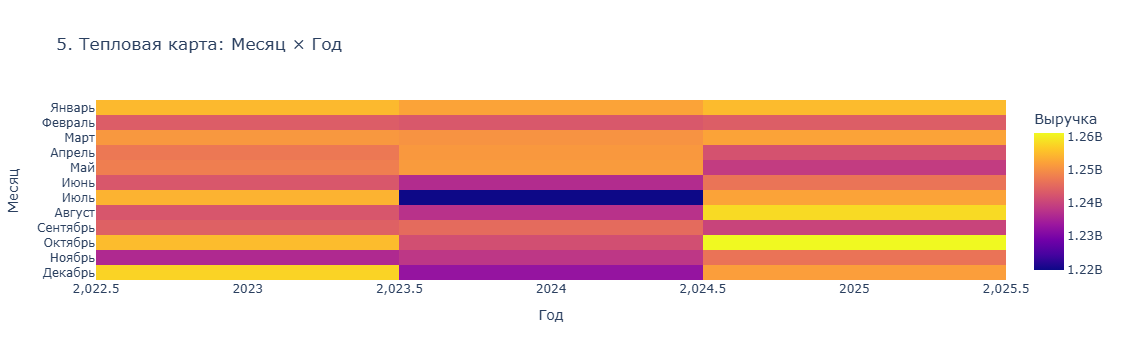

In [13]:
# График 5: Тепловая карта год × месяц
monthly_yearly = df_long.groupby(['Год', 'Месяц'])['Сумма в чеке'].sum().reset_index()
heatmap_ym = monthly_yearly.pivot(index='Месяц', columns='Год', values='Сумма в чеке')
heatmap_ym = heatmap_ym.reindex(months_order)

fig5 = px.imshow(heatmap_ym, aspect='auto',
                 title='5. Тепловая карта: Месяц × Год',
                 labels=dict(color='Выручка'))
all_figures.append(('5. Тепловая карта Год-Месяц', fig5))
fig5.show()

---
# РАЗДЕЛ 2: Анализ покупателей (20 графиков)

## 2.1 Сегментация по сумме покупок

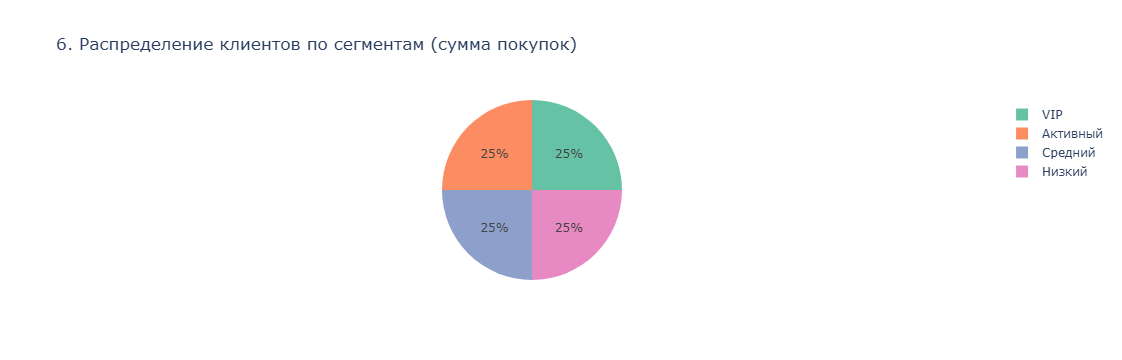

In [14]:
# График 6: Распределение клиентов по сегментам
segment_order = ['VIP', 'Активный', 'Средний', 'Низкий']
segment_counts = client_stats['Сегмент'].value_counts().reindex(segment_order)

fig6 = px.pie(values=segment_counts.values, names=segment_counts.index,
              title='6. Распределение клиентов по сегментам (сумма покупок)',
              color_discrete_sequence=px.colors.qualitative.Set2)
all_figures.append(('6. Сегменты клиентов', fig6))
fig6.show()

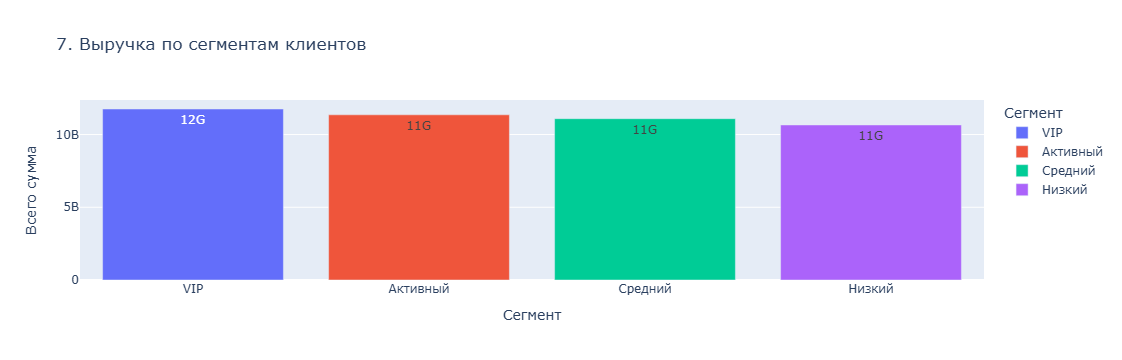

In [15]:
# График 7: Выручка по сегментам
segment_revenue = client_stats.groupby('Сегмент')['Всего сумма'].sum().reindex(segment_order).reset_index()

fig7 = px.bar(segment_revenue, x='Сегмент', y='Всего сумма',
              title='7. Выручка по сегментам клиентов',
              color='Сегмент', text_auto='.2s')
all_figures.append(('7. Выручка по сегментам', fig7))
fig7.show()

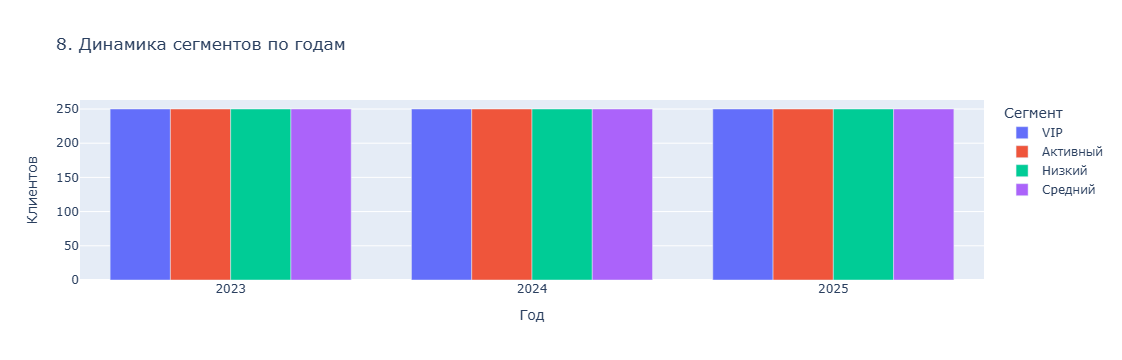

In [16]:
# График 8: Динамика сегментов по годам
df_with_segment = df_long.merge(client_stats[['client_id', 'Сегмент']], on='client_id')
yearly_segments = df_with_segment.groupby(['Год', 'Сегмент'])['client_id'].nunique().reset_index()
yearly_segments.columns = ['Год', 'Сегмент', 'Клиентов']

fig8 = px.bar(yearly_segments, x='Год', y='Клиентов', color='Сегмент',
              title='8. Динамика сегментов по годам', barmode='group')
all_figures.append(('8. Динамика сегментов', fig8))
fig8.show()

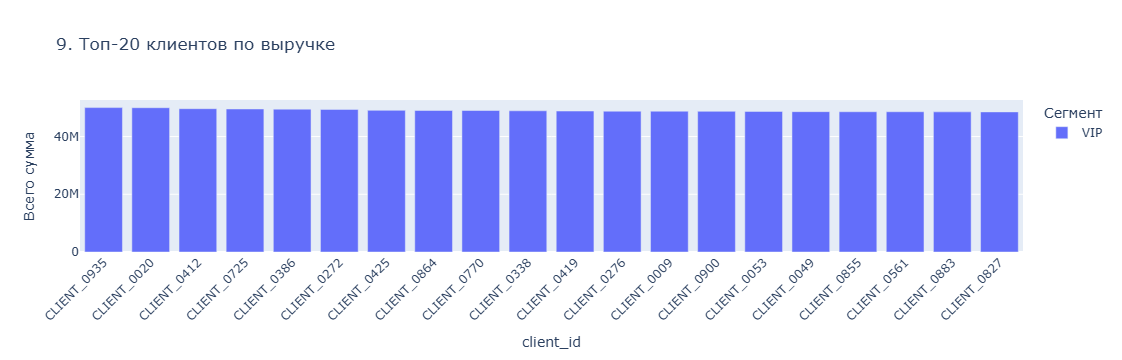

In [17]:
# График 9: Топ-20 клиентов по выручке
top20_revenue = client_stats.nlargest(20, 'Всего сумма')

fig9 = px.bar(top20_revenue, x='client_id', y='Всего сумма',
              title='9. Топ-20 клиентов по выручке',
              color='Сегмент')
fig9.update_layout(xaxis_tickangle=-45)
all_figures.append(('9. Топ-20 по выручке', fig9))
fig9.show()

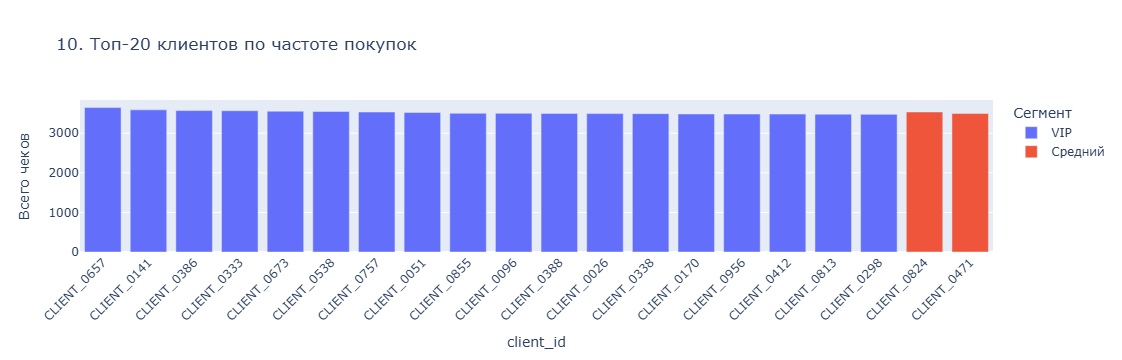

In [18]:
# График 10: Топ-20 клиентов по частоте
top20_frequency = client_stats.nlargest(20, 'Всего чеков')

fig10 = px.bar(top20_frequency, x='client_id', y='Всего чеков',
               title='10. Топ-20 клиентов по частоте покупок',
               color='Сегмент')
fig10.update_layout(xaxis_tickangle=-45)
all_figures.append(('10. Топ-20 по частоте', fig10))
fig10.show()

## 2.2 Сегментация по цене товара

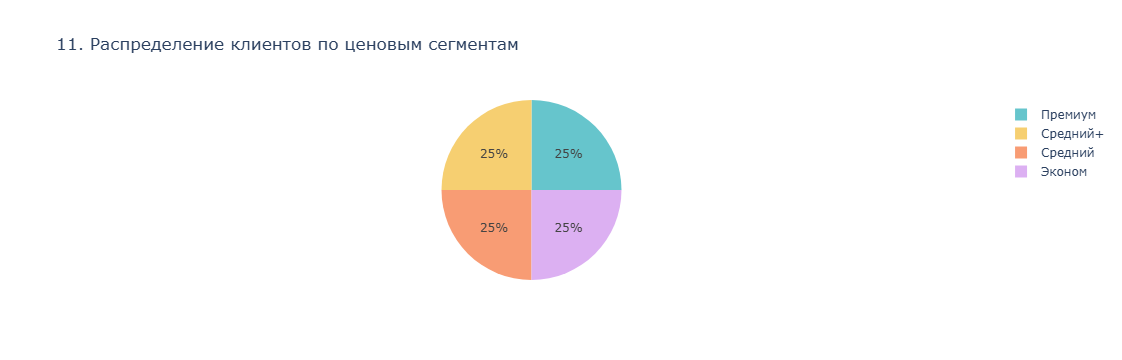

In [19]:
# График 11: Распределение по ценовым сегментам
price_segment_order = ['Премиум', 'Средний+', 'Средний', 'Эконом']
price_counts = client_stats['Ценовой сегмент'].value_counts().reindex(price_segment_order)

fig11 = px.pie(values=price_counts.values, names=price_counts.index,
               title='11. Распределение клиентов по ценовым сегментам',
               color_discrete_sequence=px.colors.qualitative.Pastel)
all_figures.append(('11. Ценовые сегменты', fig11))
fig11.show()

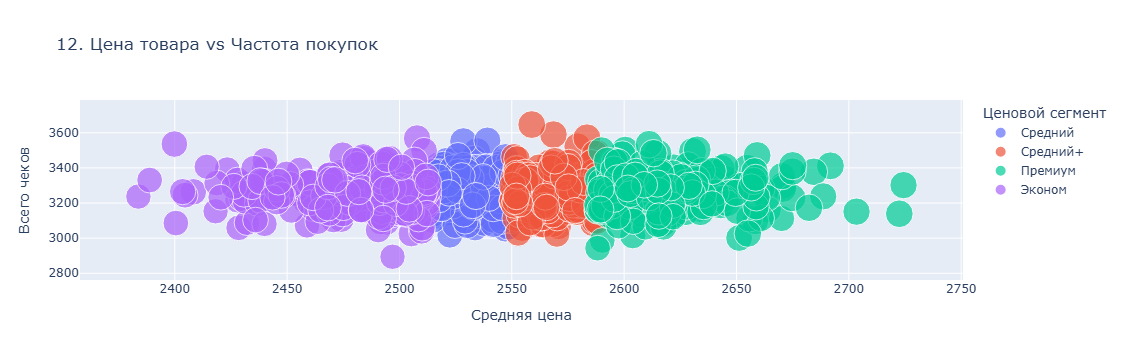

In [20]:
# График 12: Scatter - цена vs частота
fig12 = px.scatter(client_stats, x='Средняя цена', y='Всего чеков',
                   color='Ценовой сегмент', size='Всего сумма',
                   hover_data=['client_id'],
                   title='12. Цена товара vs Частота покупок')
all_figures.append(('12. Цена vs Частота', fig12))
fig12.show()

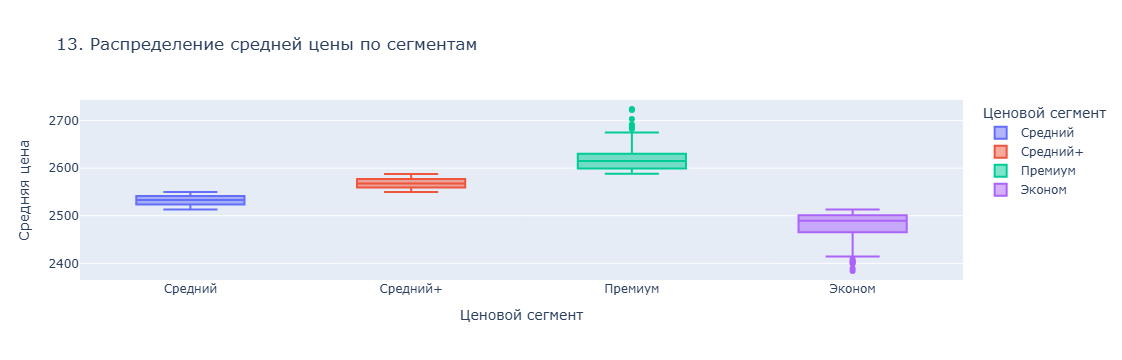

In [21]:
# График 13: Box plot цен по сегментам
fig13 = px.box(client_stats, x='Ценовой сегмент', y='Средняя цена',
               title='13. Распределение средней цены по сегментам',
               color='Ценовой сегмент')
all_figures.append(('13. Box plot цен', fig13))
fig13.show()

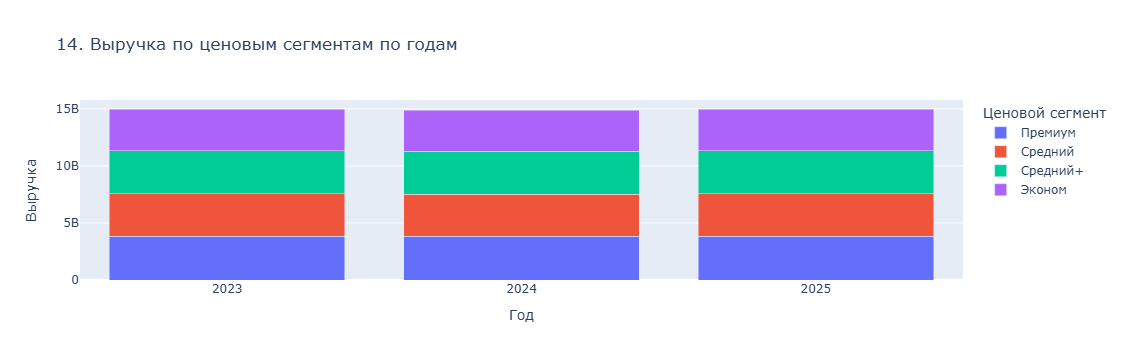

In [25]:
# График 14: Динамика ценовых сегментов по годам
df_with_price_seg = df_long.merge(client_stats[['client_id', 'Ценовой сегмент']], on='client_id')
yearly_price_seg = df_with_price_seg.groupby(['Год', 'Ценовой сегмент']).agg({
    'client_id': 'nunique',
    'Сумма в чеке': 'sum'
}).reset_index()
yearly_price_seg.columns = ['Год', 'Ценовой сегмент', 'Клиентов', 'Выручка']

fig14 = px.bar(yearly_price_seg, x='Год', y='Выручка', color='Ценовой сегмент',
               title='14. Выручка по ценовым сегментам по годам', barmode='stack')
all_figures.append(('14. Выручка ценовых сегментов', fig14))
fig14.show()

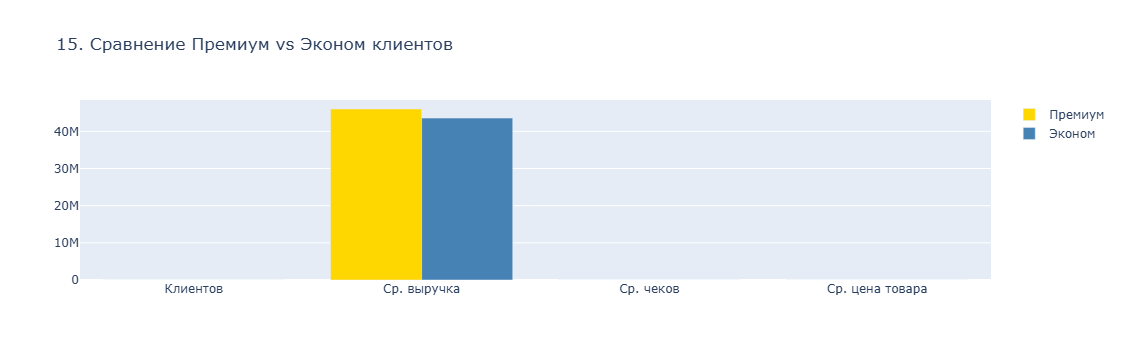

In [26]:
# График 15: Сравнение Премиум vs Эконом
premium = client_stats[client_stats['Ценовой сегмент'] == 'Премиум']
economy = client_stats[client_stats['Ценовой сегмент'] == 'Эконом']

comparison_data = pd.DataFrame({
    'Показатель': ['Клиентов', 'Ср. выручка', 'Ср. чеков', 'Ср. цена товара'],
    'Премиум': [len(premium), premium['Всего сумма'].mean(), premium['Всего чеков'].mean(), premium['Средняя цена'].mean()],
    'Эконом': [len(economy), economy['Всего сумма'].mean(), economy['Всего чеков'].mean(), economy['Средняя цена'].mean()]
})

fig15 = go.Figure()
fig15.add_trace(go.Bar(name='Премиум', x=comparison_data['Показатель'], y=comparison_data['Премиум'], marker_color='gold'))
fig15.add_trace(go.Bar(name='Эконом', x=comparison_data['Показатель'], y=comparison_data['Эконом'], marker_color='steelblue'))
fig15.update_layout(title='15. Сравнение Премиум vs Эконом клиентов', barmode='group')
all_figures.append(('15. Премиум vs Эконом', fig15))
fig15.show()

In [28]:
# График 20б: Sankey 2024 → 2025
sankey_labels_2 = ['Премиум 2024', 'Средний+ 2024', 'Средний 2024', 'Эконом 2024',
                   'Премиум 2025', 'Средний+ 2025', 'Средний 2025', 'Эконом 2025']

source2 = []
target2 = []
value2 = []

for i, from_seg in enumerate(price_segment_order):
    for j, to_seg in enumerate(price_segment_order):
        v = mig_2024_2025.loc[from_seg, to_seg]
        if v > 0:
            source2.append(i)
            target2.append(4 + j)
            value2.append(v)

fig20b = go.Figure(data=[go.Sankey(
    node=dict(label=sankey_labels_2, pad=15, thickness=20,
              color=['gold', 'orange', 'lightblue', 'steelblue', 'gold', 'orange', 'lightblue', 'steelblue']),
    link=dict(source=source2, target=target2, value=value2)
)])
fig20b.update_layout(title='20б. Sankey: Миграция клиентов 2024 → 2025')
all_figures.append(('20б. Sankey 2024-2025', fig20b))
fig20b.show()

NameError: name 'mig_2024_2025' is not defined

In [29]:
# График 20в: Sankey 2023 → 2025 (полный период)
mig_2023_2025 = build_migration_matrix(seg_2023, seg_2025)

sankey_labels_3 = ['Премиум 2023', 'Средний+ 2023', 'Средний 2023', 'Эконом 2023',
                   'Премиум 2025', 'Средний+ 2025', 'Средний 2025', 'Эконом 2025']

source3 = []
target3 = []
value3 = []

for i, from_seg in enumerate(price_segment_order):
    for j, to_seg in enumerate(price_segment_order):
        v = mig_2023_2025.loc[from_seg, to_seg]
        if v > 0:
            source3.append(i)
            target3.append(4 + j)
            value3.append(v)

fig20c = go.Figure(data=[go.Sankey(
    node=dict(label=sankey_labels_3, pad=15, thickness=20,
              color=['#2ecc71', '#f39c12', '#3498db', '#9b59b6', '#2ecc71', '#f39c12', '#3498db', '#9b59b6']),
    link=dict(source=source3, target=target3, value=value3)
)])
fig20c.update_layout(title='20в. Sankey: Миграция клиентов 2023 → 2025 (полный период)')
all_figures.append(('20в. Sankey 2023-2025', fig20c))
fig20c.show()

# Вывод статистики миграции
print('=== Миграция 2023 → 2025 ===')
print(mig_2023_2025)
print(f'\nВсего клиентов в обоих периодах: {mig_2023_2025.sum().sum()}')

NameError: name 'build_migration_matrix' is not defined

## 2.3 Когортный анализ

In [30]:
# Подготовка данных для когортного анализа
yearly_client_segments = df_long.groupby(['Год', 'client_id']).agg({
    'Средняя цена товара': 'mean'
}).reset_index()
yearly_client_segments['Ценовой сегмент'] = yearly_client_segments['Средняя цена товара'].apply(segment_by_price)

def get_segments_dict(year):
    data = yearly_client_segments[yearly_client_segments['Год'] == year]
    return dict(zip(data['client_id'], data['Ценовой сегмент']))

seg_2023 = get_segments_dict(2023)
seg_2024 = get_segments_dict(2024)
seg_2025 = get_segments_dict(2025)

clients_2023 = set(seg_2023.keys())
clients_2024 = set(seg_2024.keys())
clients_2025 = set(seg_2025.keys())

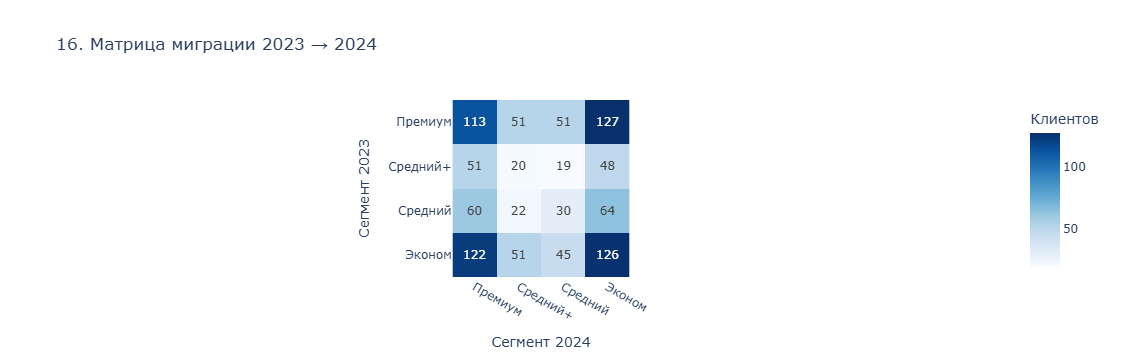

In [31]:
# Графики 16-17: Матрицы миграции
def build_migration_matrix(from_seg, to_seg):
    segments = ['Премиум', 'Средний+', 'Средний', 'Эконом']
    matrix = pd.DataFrame(0, index=segments, columns=segments)
    common = set(from_seg.keys()) & set(to_seg.keys())
    for client in common:
        matrix.loc[from_seg[client], to_seg[client]] += 1
    return matrix

mig_2023_2024 = build_migration_matrix(seg_2023, seg_2024)
mig_2024_2025 = build_migration_matrix(seg_2024, seg_2025)

# График 16
fig16 = px.imshow(mig_2023_2024, text_auto=True,
                  title='16. Матрица миграции 2023 → 2024',
                  labels=dict(x='Сегмент 2024', y='Сегмент 2023', color='Клиентов'),
                  color_continuous_scale='Blues')
all_figures.append(('16. Миграция 2023-2024', fig16))
fig16.show()

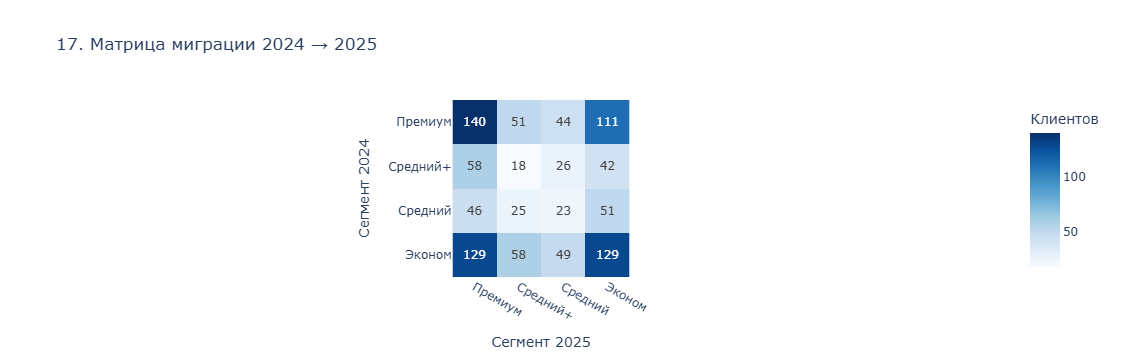

In [32]:
# График 17
fig17 = px.imshow(mig_2024_2025, text_auto=True,
                  title='17. Матрица миграции 2024 → 2025',
                  labels=dict(x='Сегмент 2025', y='Сегмент 2024', color='Клиентов'),
                  color_continuous_scale='Blues')
all_figures.append(('17. Миграция 2024-2025', fig17))
fig17.show()

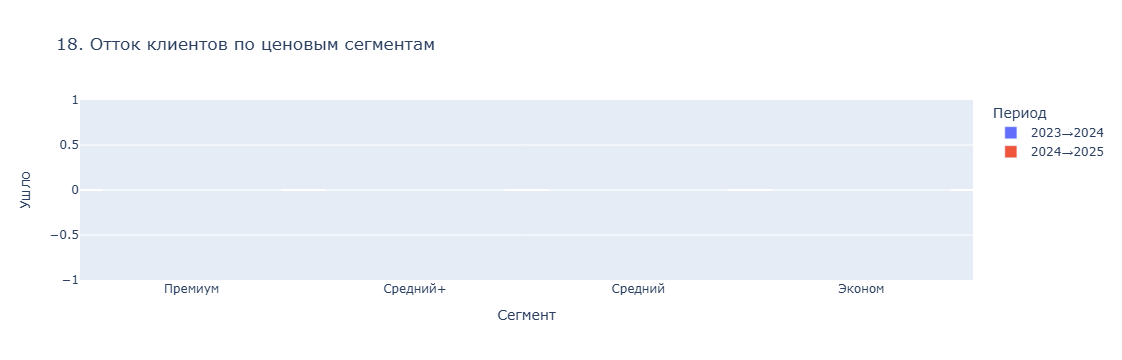

In [33]:
# График 18: Отток по сегментам
churned_2024 = clients_2023 - clients_2024
churned_2025 = clients_2024 - clients_2025

def churn_by_segment(churned, seg_dict):
    result = {}
    for c in churned:
        if c in seg_dict:
            s = seg_dict[c]
            result[s] = result.get(s, 0) + 1
    return result

churn_2024_seg = churn_by_segment(churned_2024, seg_2023)
churn_2025_seg = churn_by_segment(churned_2025, seg_2024)

churn_df = pd.DataFrame([
    {'Период': '2023→2024', 'Сегмент': s, 'Ушло': churn_2024_seg.get(s, 0)}
    for s in price_segment_order
] + [
    {'Период': '2024→2025', 'Сегмент': s, 'Ушло': churn_2025_seg.get(s, 0)}
    for s in price_segment_order
])

fig18 = px.bar(churn_df, x='Сегмент', y='Ушло', color='Период',
               title='18. Отток клиентов по ценовым сегментам', barmode='group')
all_figures.append(('18. Отток по сегментам', fig18))
fig18.show()

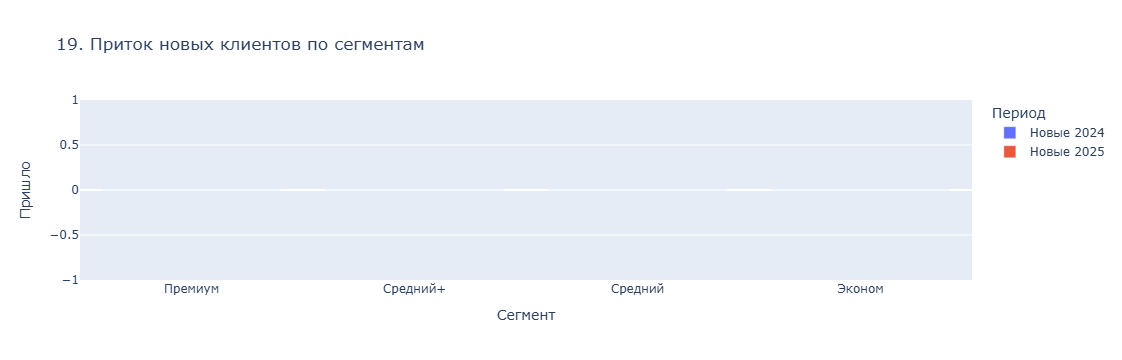

In [34]:
# График 19: Приток новых клиентов
new_2024 = clients_2024 - clients_2023
new_2025 = clients_2025 - clients_2024

def new_by_segment(new_clients, seg_dict):
    result = {}
    for c in new_clients:
        if c in seg_dict:
            s = seg_dict[c]
            result[s] = result.get(s, 0) + 1
    return result

new_2024_seg = new_by_segment(new_2024, seg_2024)
new_2025_seg = new_by_segment(new_2025, seg_2025)

new_df = pd.DataFrame([
    {'Период': 'Новые 2024', 'Сегмент': s, 'Пришло': new_2024_seg.get(s, 0)}
    for s in price_segment_order
] + [
    {'Период': 'Новые 2025', 'Сегмент': s, 'Пришло': new_2025_seg.get(s, 0)}
    for s in price_segment_order
])

fig19 = px.bar(new_df, x='Сегмент', y='Пришло', color='Период',
               title='19. Приток новых клиентов по сегментам', barmode='group')
all_figures.append(('19. Приток по сегментам', fig19))
fig19.show()

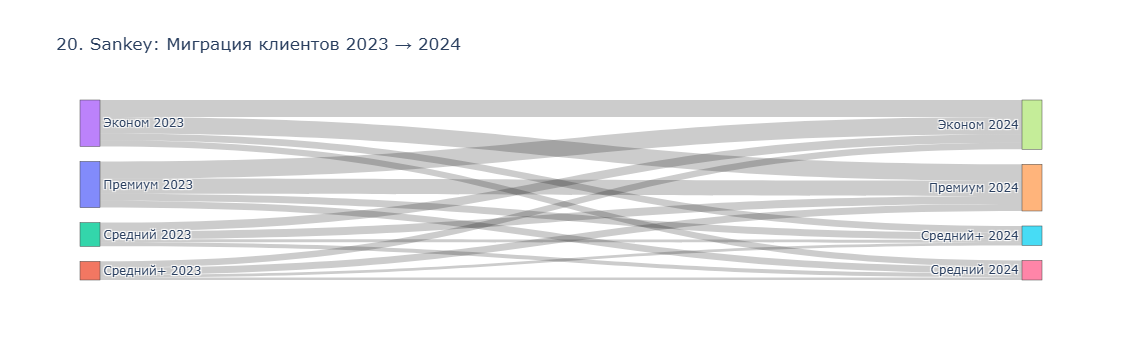

In [35]:
# График 20: Sankey диаграмма миграции
# Подготовка данных для Sankey
sankey_labels = ['Премиум 2023', 'Средний+ 2023', 'Средний 2023', 'Эконом 2023',
                 'Премиум 2024', 'Средний+ 2024', 'Средний 2024', 'Эконом 2024']

source = []
target = []
value = []

for i, from_seg in enumerate(price_segment_order):
    for j, to_seg in enumerate(price_segment_order):
        v = mig_2023_2024.loc[from_seg, to_seg]
        if v > 0:
            source.append(i)
            target.append(4 + j)
            value.append(v)

fig20 = go.Figure(data=[go.Sankey(
    node=dict(label=sankey_labels, pad=15, thickness=20),
    link=dict(source=source, target=target, value=value)
)])
fig20.update_layout(title='20. Sankey: Миграция клиентов 2023 → 2024')
all_figures.append(('20. Sankey миграция', fig20))
fig20.show()

## 2.4 Поведение покупателей

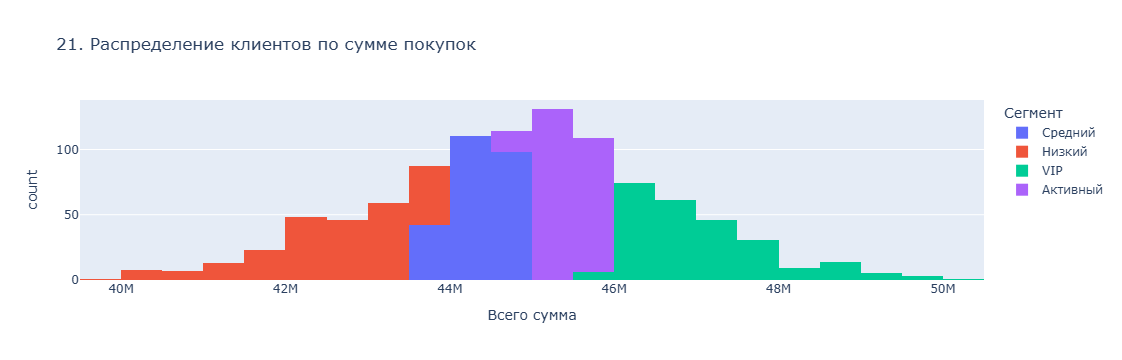

In [36]:
# График 21: Histogram по сумме
fig21 = px.histogram(client_stats, x='Всего сумма', nbins=50,
                     title='21. Распределение клиентов по сумме покупок',
                     color='Сегмент')
all_figures.append(('21. Распределение по сумме', fig21))
fig21.show()

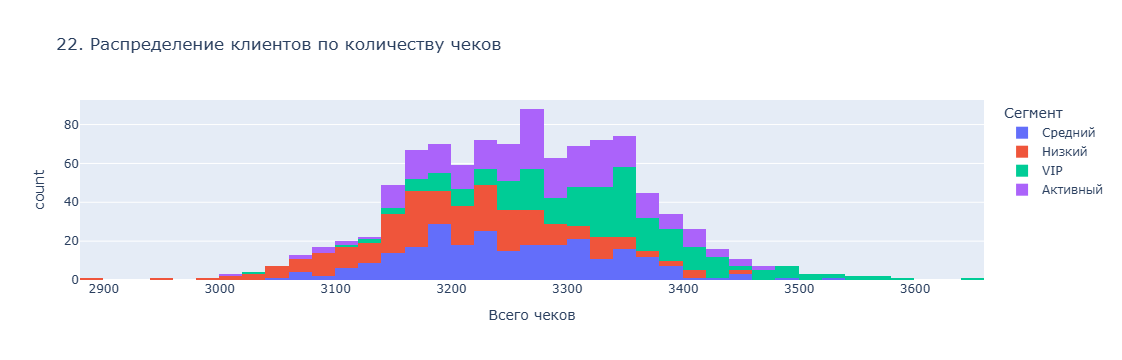

In [37]:
# График 22: Histogram по частоте
fig22 = px.histogram(client_stats, x='Всего чеков', nbins=50,
                     title='22. Распределение клиентов по количеству чеков',
                     color='Сегмент')
all_figures.append(('22. Распределение по чекам', fig22))
fig22.show()

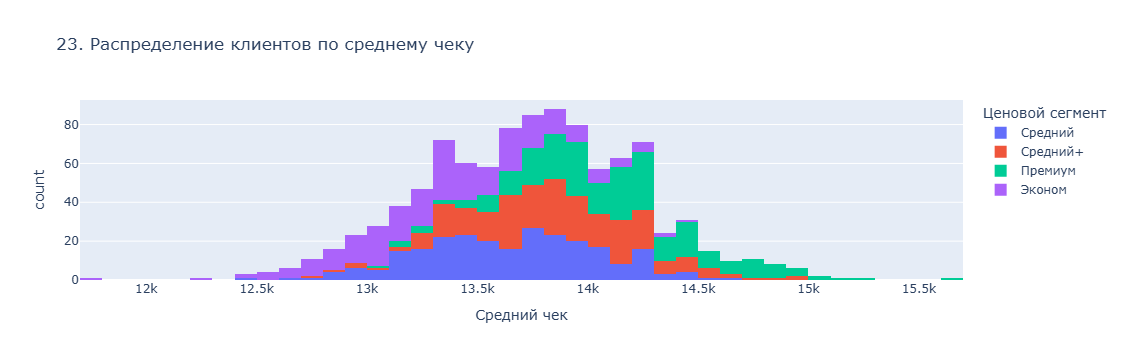

In [38]:
# График 23: Histogram по среднему чеку
fig23 = px.histogram(client_stats, x='Средний чек', nbins=50,
                     title='23. Распределение клиентов по среднему чеку',
                     color='Ценовой сегмент')
all_figures.append(('23. Распределение по ср. чеку', fig23))
fig23.show()

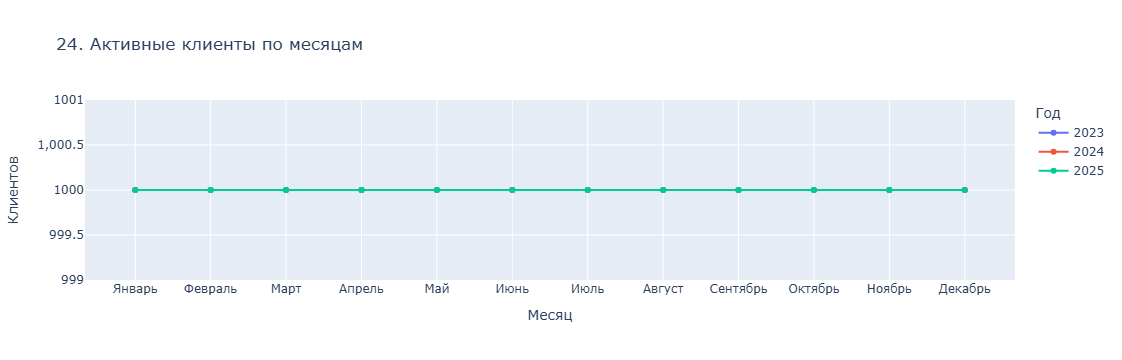

In [39]:
# График 24: Динамика активных клиентов по месяцам
monthly_active = df_long.groupby(['Год', 'Месяц'])['client_id'].nunique().reset_index()
monthly_active.columns = ['Год', 'Месяц', 'Клиентов']

fig24 = px.line(monthly_active, x='Месяц', y='Клиентов', color='Год',
                title='24. Активные клиенты по месяцам', markers=True,
                category_orders={'Месяц': months_order})
all_figures.append(('24. Активность по месяцам', fig24))
fig24.show()

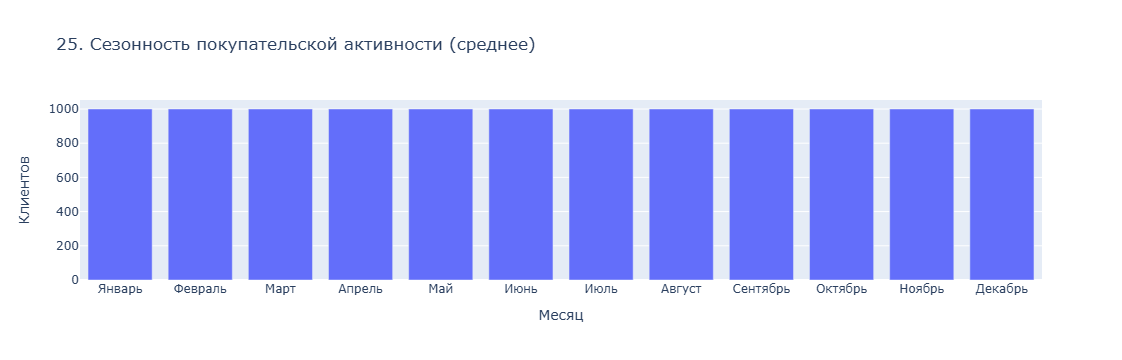

In [40]:
# График 25: Сезонность активности (средняя по годам)
seasonality = monthly_active.groupby('Месяц')['Клиентов'].mean().reindex(months_order).reset_index()

fig25 = px.bar(seasonality, x='Месяц', y='Клиентов',
               title='25. Сезонность покупательской активности (среднее)')
all_figures.append(('25. Сезонность активности', fig25))
fig25.show()

---
# РАЗДЕЛ 3: Анализ групп товаров (15 графиков)

## 3.1 Общая статистика

In [41]:
# Агрегаты по группам
group_stats = df_long.groupby('Группа').agg({
    'Сумма в чеке': 'sum',
    'Количество в чеке': 'sum',
    'Число чеков': 'sum',
    'Средняя цена товара': 'mean'
}).reset_index()
group_stats.columns = ['Группа', 'Выручка', 'Количество', 'Чеков', 'Ср. цена']
group_stats = group_stats.sort_values('Выручка', ascending=False)

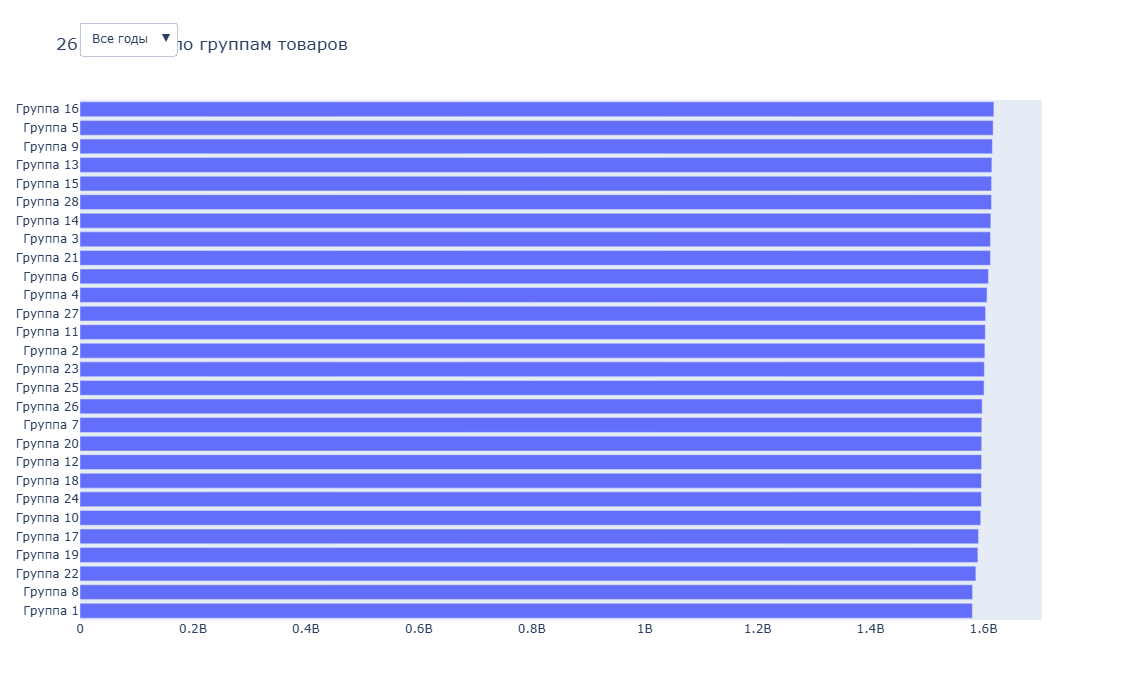

In [42]:
# График 26: Выручка по группам с dropdown по году
group_year_rev = df_long.groupby(['Год', 'Группа'])['Сумма в чеке'].sum().reset_index()

fig26 = go.Figure()

# Все годы
all_groups = group_stats.sort_values('Выручка', ascending=True)
fig26.add_trace(go.Bar(x=all_groups['Выручка'], y=all_groups['Группа'],
                       orientation='h', name='Все годы', visible=True))

# По годам
for year in [2023, 2024, 2025]:
    year_data = group_year_rev[group_year_rev['Год'] == year].sort_values('Сумма в чеке', ascending=True)
    fig26.add_trace(go.Bar(x=year_data['Сумма в чеке'], y=year_data['Группа'],
                           orientation='h', name=str(year), visible=False))

# Dropdown
fig26.update_layout(
    title='26. Выручка по группам товаров',
    updatemenus=[dict(
        active=0,
        buttons=[
            dict(label='Все годы', method='update', args=[{'visible': [True, False, False, False]}]),
            dict(label='2023', method='update', args=[{'visible': [False, True, False, False]}]),
            dict(label='2024', method='update', args=[{'visible': [False, False, True, False]}]),
            dict(label='2025', method='update', args=[{'visible': [False, False, False, True]}])
        ],
        x=0.1, y=1.15
    )],
    height=700
)
all_figures.append(('26. Выручка по группам (dropdown)', fig26))
fig26.show()

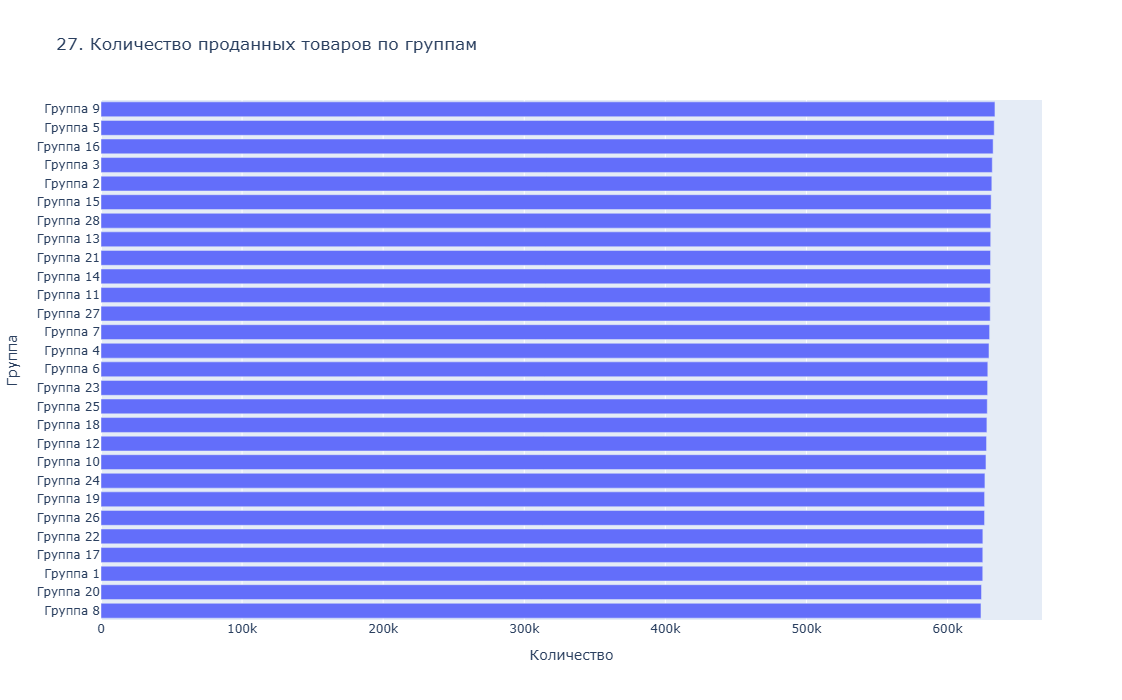

In [43]:
# График 27: Количество продаж по группам
fig27 = px.bar(group_stats.sort_values('Количество', ascending=True), 
               x='Количество', y='Группа', orientation='h',
               title='27. Количество проданных товаров по группам')
fig27.update_layout(height=700)
all_figures.append(('27. Количество по группам', fig27))
fig27.show()

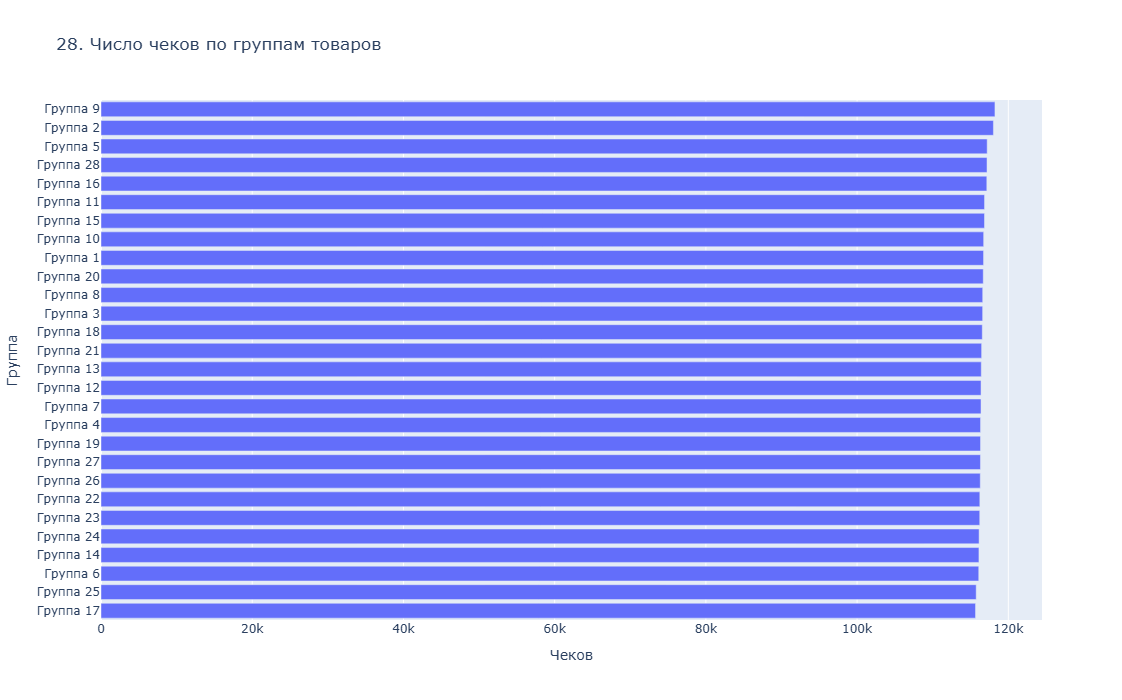

In [44]:
# График 28: Число чеков по группам
fig28 = px.bar(group_stats.sort_values('Чеков', ascending=True),
               x='Чеков', y='Группа', orientation='h',
               title='28. Число чеков по группам товаров')
fig28.update_layout(height=700)
all_figures.append(('28. Чеков по группам', fig28))
fig28.show()

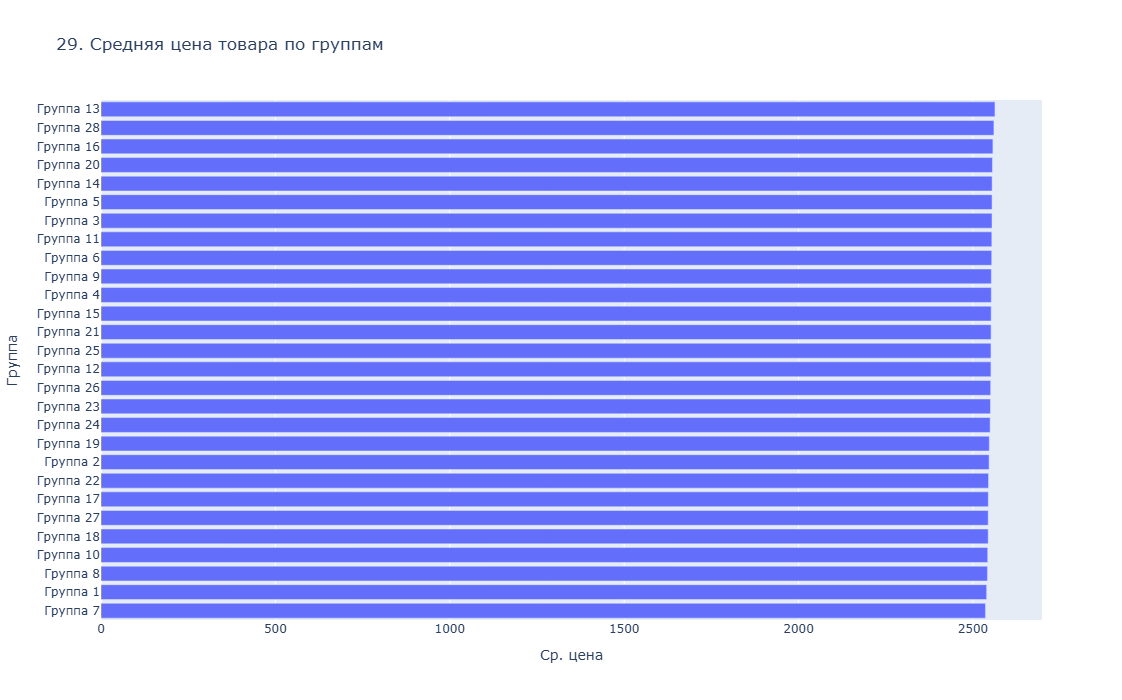

In [45]:
# График 29: Средняя цена товара по группам
fig29 = px.bar(group_stats.sort_values('Ср. цена', ascending=True),
               x='Ср. цена', y='Группа', orientation='h',
               title='29. Средняя цена товара по группам')
fig29.update_layout(height=700)
all_figures.append(('29. Ср. цена по группам', fig29))
fig29.show()

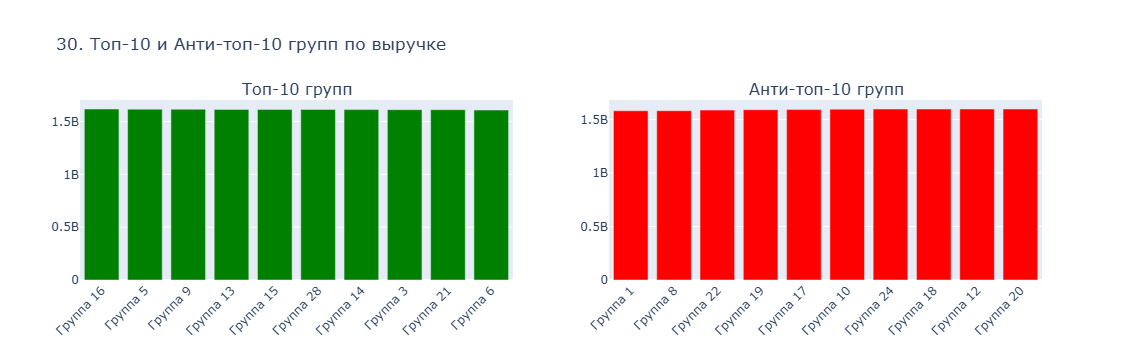

In [46]:
# График 30: Топ-10 / Анти-топ-10
top10 = group_stats.nlargest(10, 'Выручка')
bottom10 = group_stats.nsmallest(10, 'Выручка')

fig30 = make_subplots(rows=1, cols=2, subplot_titles=['Топ-10 групп', 'Анти-топ-10 групп'])
fig30.add_trace(go.Bar(x=top10['Группа'], y=top10['Выручка'], marker_color='green', name='Топ'), row=1, col=1)
fig30.add_trace(go.Bar(x=bottom10['Группа'], y=bottom10['Выручка'], marker_color='red', name='Анти-топ'), row=1, col=2)
fig30.update_layout(title='30. Топ-10 и Анти-топ-10 групп по выручке', showlegend=False)
fig30.update_xaxes(tickangle=-45)
all_figures.append(('30. Топ и Анти-топ', fig30))
fig30.show()

## 3.2 Динамика

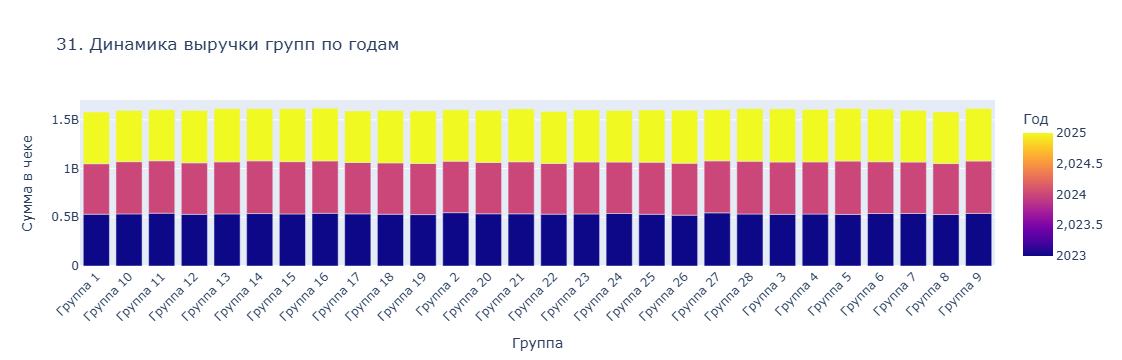

In [47]:
# График 31: Динамика групп по годам
fig31 = px.bar(group_year_rev, x='Группа', y='Сумма в чеке', color='Год',
               title='31. Динамика выручки групп по годам', barmode='group')
fig31.update_layout(xaxis_tickangle=-45)
all_figures.append(('31. Динамика групп', fig31))
fig31.show()

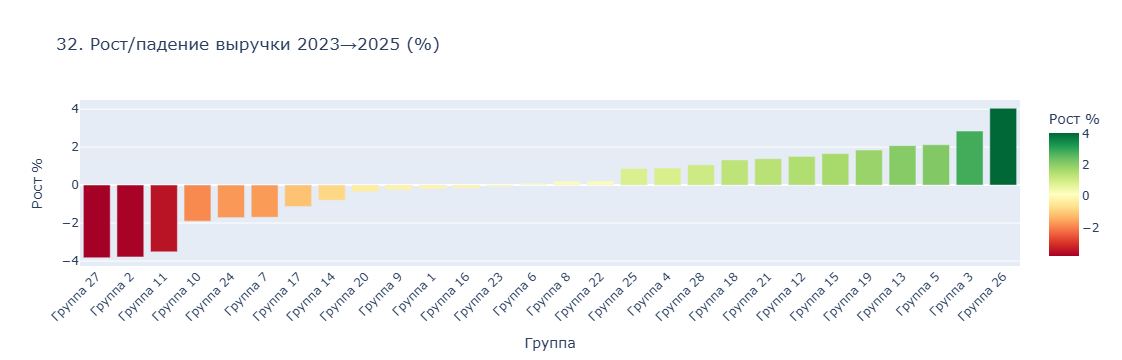

In [48]:
# График 32: Рост/падение групп 2023→2025
rev_2023 = group_year_rev[group_year_rev['Год'] == 2023].set_index('Группа')['Сумма в чеке']
rev_2025 = group_year_rev[group_year_rev['Год'] == 2025].set_index('Группа')['Сумма в чеке']
growth = ((rev_2025 - rev_2023) / rev_2023 * 100).reset_index()
growth.columns = ['Группа', 'Рост %']
growth = growth.sort_values('Рост %')

fig32 = px.bar(growth, x='Группа', y='Рост %',
               title='32. Рост/падение выручки 2023→2025 (%)',
               color='Рост %', color_continuous_scale='RdYlGn')
fig32.update_layout(xaxis_tickangle=-45)
all_figures.append(('32. Рост 2023-2025', fig32))
fig32.show()

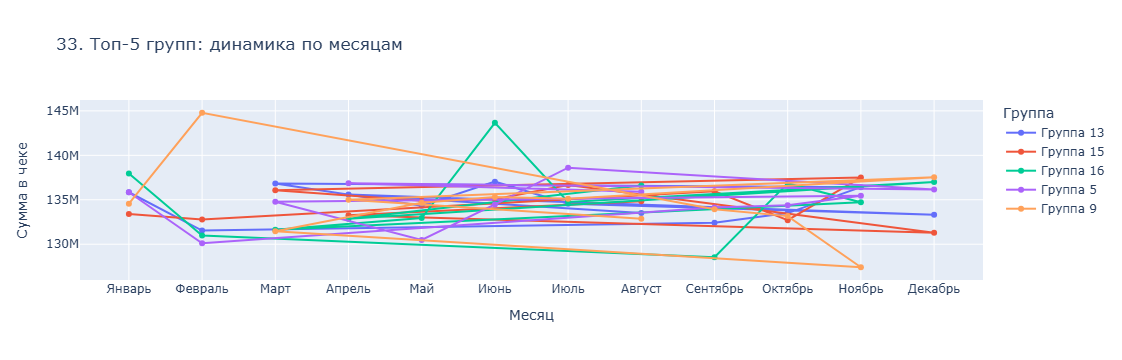

In [49]:
# График 33: Топ-5 групп по месяцам
top5_groups = group_stats.nlargest(5, 'Выручка')['Группа'].tolist()
top5_monthly = df_long[df_long['Группа'].isin(top5_groups)].groupby(['Месяц', 'Группа'])['Сумма в чеке'].sum().reset_index()

fig33 = px.line(top5_monthly, x='Месяц', y='Сумма в чеке', color='Группа',
                title='33. Топ-5 групп: динамика по месяцам', markers=True,
                category_orders={'Месяц': months_order})
all_figures.append(('33. Топ-5 по месяцам', fig33))
fig33.show()

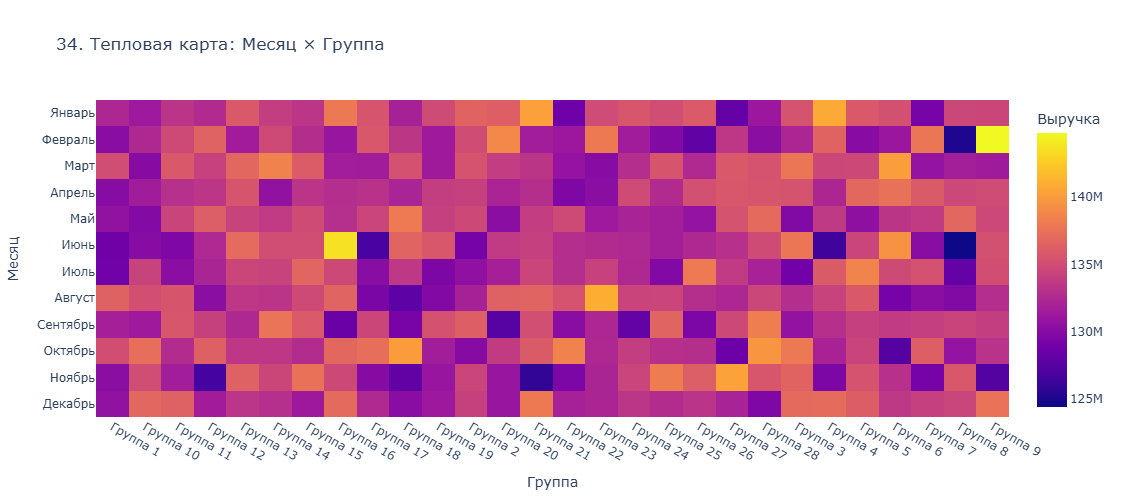

In [50]:
# График 34: Тепловая карта группа × месяц
group_month = df_long.groupby(['Месяц', 'Группа'])['Сумма в чеке'].sum().reset_index()
heatmap_gm = group_month.pivot(index='Месяц', columns='Группа', values='Сумма в чеке')
heatmap_gm = heatmap_gm.reindex(months_order)

fig34 = px.imshow(heatmap_gm, aspect='auto',
                  title='34. Тепловая карта: Месяц × Группа',
                  labels=dict(color='Выручка'))
fig34.update_layout(height=500)
all_figures.append(('34. Тепловая Месяц-Группа', fig34))
fig34.show()

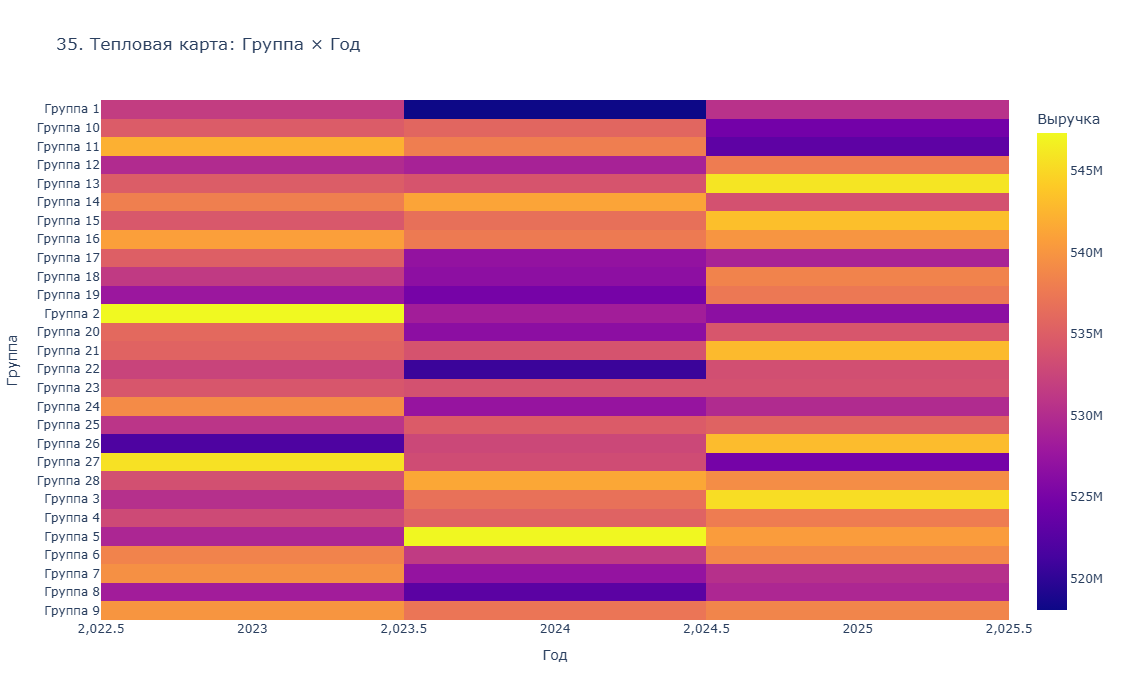

In [51]:
# График 35: Тепловая карта группа × год
group_year = df_long.groupby(['Год', 'Группа'])['Сумма в чеке'].sum().reset_index()
heatmap_gy = group_year.pivot(index='Группа', columns='Год', values='Сумма в чеке')

fig35 = px.imshow(heatmap_gy, aspect='auto',
                  title='35. Тепловая карта: Группа × Год',
                  labels=dict(color='Выручка'))
fig35.update_layout(height=700)
all_figures.append(('35. Тепловая Группа-Год', fig35))
fig35.show()

## 3.3 Сезонность

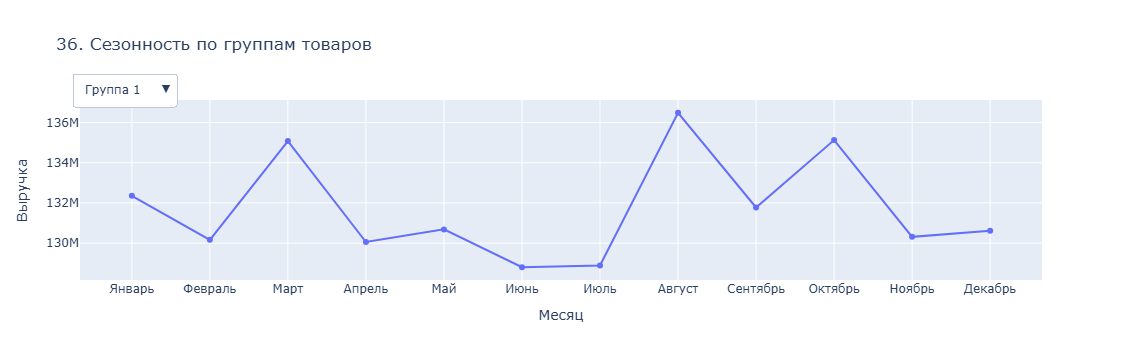

In [52]:
# График 36: Сезонность по группам с dropdown
all_groups_list = sorted(df_long['Группа'].unique())

fig36 = go.Figure()

for i, group in enumerate(all_groups_list):
    group_data = df_long[df_long['Группа'] == group].groupby('Месяц')['Сумма в чеке'].sum().reindex(months_order)
    fig36.add_trace(go.Scatter(x=months_order, y=group_data.values, mode='lines+markers',
                               name=group, visible=(i == 0)))

# Dropdown для выбора группы
buttons = []
for i, group in enumerate(all_groups_list):
    visible = [False] * len(all_groups_list)
    visible[i] = True
    buttons.append(dict(label=group, method='update', args=[{'visible': visible}]))

fig36.update_layout(
    title='36. Сезонность по группам товаров',
    updatemenus=[dict(active=0, buttons=buttons, x=0.1, y=1.15)],
    xaxis_title='Месяц', yaxis_title='Выручка'
)
all_figures.append(('36. Сезонность групп (dropdown)', fig36))
fig36.show()

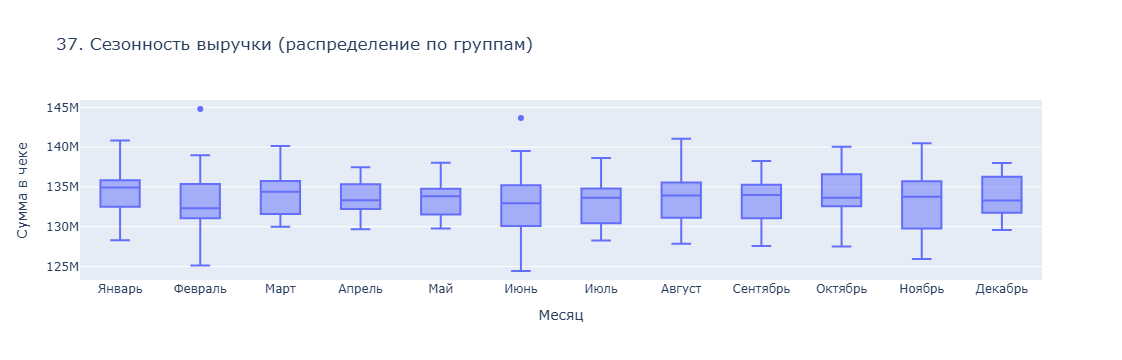

In [53]:
# График 37: Box plot сезонности
monthly_groups = df_long.groupby(['Месяц', 'Группа'])['Сумма в чеке'].sum().reset_index()

fig37 = px.box(monthly_groups, x='Месяц', y='Сумма в чеке',
               title='37. Сезонность выручки (распределение по группам)',
               category_orders={'Месяц': months_order})
all_figures.append(('37. Box сезонности', fig37))
fig37.show()

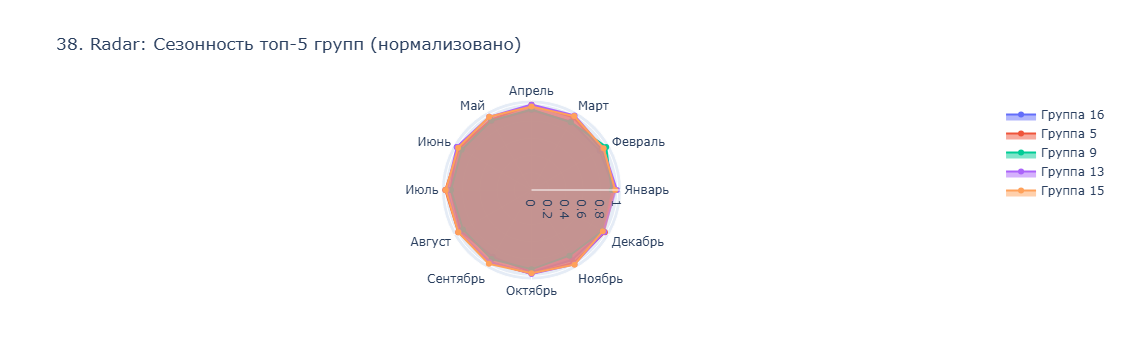

In [54]:
# График 38: Radar сезонности топ-5 групп
fig38 = go.Figure()

for group in top5_groups:
    group_data = df_long[df_long['Группа'] == group].groupby('Месяц')['Сумма в чеке'].sum().reindex(months_order)
    # Нормализуем для сравнения
    normalized = group_data / group_data.max()
    fig38.add_trace(go.Scatterpolar(r=normalized.values, theta=months_order, name=group, fill='toself'))

fig38.update_layout(title='38. Radar: Сезонность топ-5 групп (нормализовано)')
all_figures.append(('38. Radar сезонности', fig38))
fig38.show()

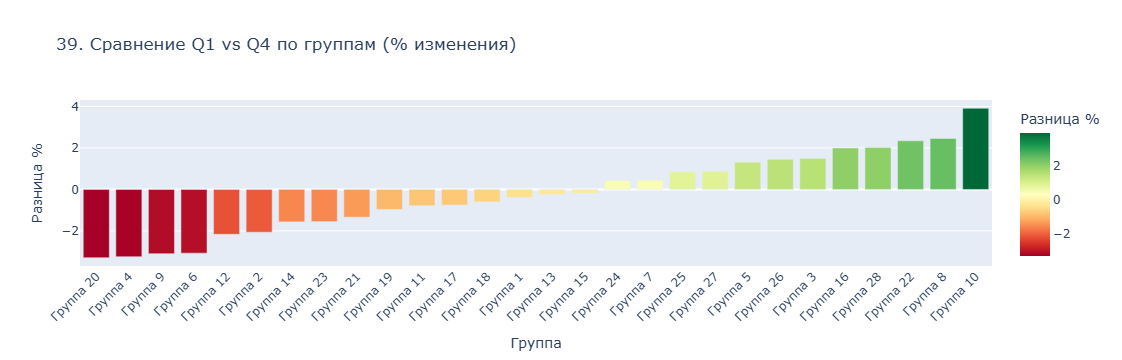

In [55]:
# График 39: Q1 vs Q4
q1_months = ['Январь', 'Февраль', 'Март']
q4_months = ['Октябрь', 'Ноябрь', 'Декабрь']

q1_data = df_long[df_long['Месяц'].isin(q1_months)].groupby('Группа')['Сумма в чеке'].sum()
q4_data = df_long[df_long['Месяц'].isin(q4_months)].groupby('Группа')['Сумма в чеке'].sum()

q_compare = pd.DataFrame({'Группа': q1_data.index, 'Q1': q1_data.values, 'Q4': q4_data.values})
q_compare['Разница %'] = (q_compare['Q4'] - q_compare['Q1']) / q_compare['Q1'] * 100
q_compare = q_compare.sort_values('Разница %')

fig39 = px.bar(q_compare, x='Группа', y='Разница %',
               title='39. Сравнение Q1 vs Q4 по группам (% изменения)',
               color='Разница %', color_continuous_scale='RdYlGn')
fig39.update_layout(xaxis_tickangle=-45)
all_figures.append(('39. Q1 vs Q4', fig39))
fig39.show()

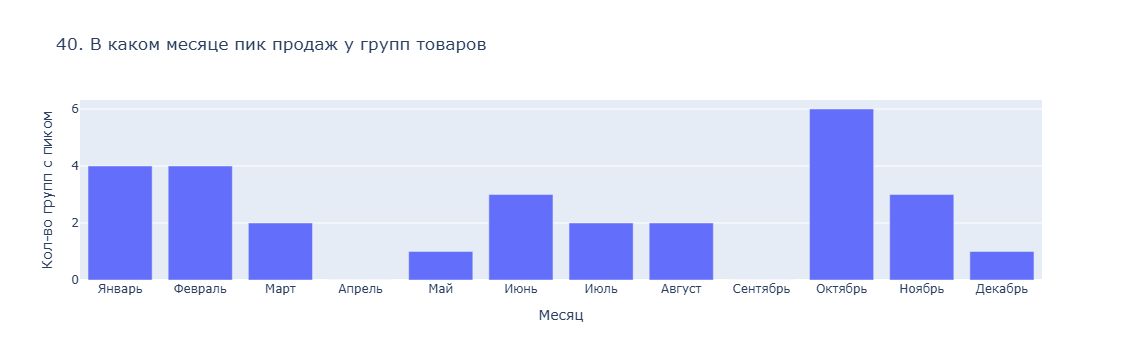

In [56]:
# График 40: Месяц пиковых продаж
peak_months = df_long.groupby(['Группа', 'Месяц'])['Сумма в чеке'].sum().reset_index()
peak_months = peak_months.loc[peak_months.groupby('Группа')['Сумма в чеке'].idxmax()]

peak_count = peak_months['Месяц'].value_counts().reindex(months_order).fillna(0)

fig40 = px.bar(x=peak_count.index, y=peak_count.values,
               title='40. В каком месяце пик продаж у групп товаров',
               labels={'x': 'Месяц', 'y': 'Кол-во групп с пиком'})
all_figures.append(('40. Месяц пика', fig40))
fig40.show()

---
# РАЗДЕЛ 4: Связь покупателей и групп (10 графиков)

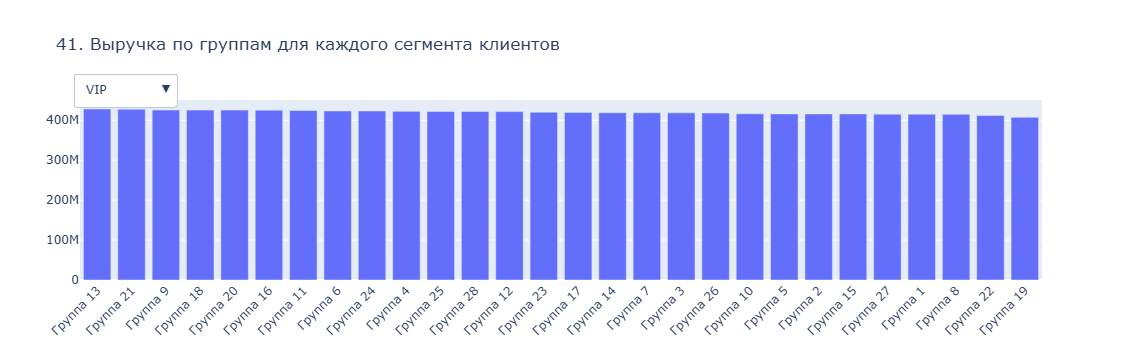

In [57]:
# График 41: Группы по сегментам с dropdown
df_seg_group = df_long.merge(client_stats[['client_id', 'Сегмент', 'Ценовой сегмент']], on='client_id')
seg_group_rev = df_seg_group.groupby(['Сегмент', 'Группа'])['Сумма в чеке'].sum().reset_index()

fig41 = go.Figure()

for i, segment in enumerate(segment_order):
    seg_data = seg_group_rev[seg_group_rev['Сегмент'] == segment].sort_values('Сумма в чеке', ascending=False)
    fig41.add_trace(go.Bar(x=seg_data['Группа'], y=seg_data['Сумма в чеке'],
                           name=segment, visible=(i == 0)))

buttons = []
for i, segment in enumerate(segment_order):
    visible = [False] * len(segment_order)
    visible[i] = True
    buttons.append(dict(label=segment, method='update', args=[{'visible': visible}]))

fig41.update_layout(
    title='41. Выручка по группам для каждого сегмента клиентов',
    updatemenus=[dict(active=0, buttons=buttons, x=0.1, y=1.15)],
    xaxis_tickangle=-45
)
all_figures.append(('41. Группы по сегментам (dropdown)', fig41))
fig41.show()

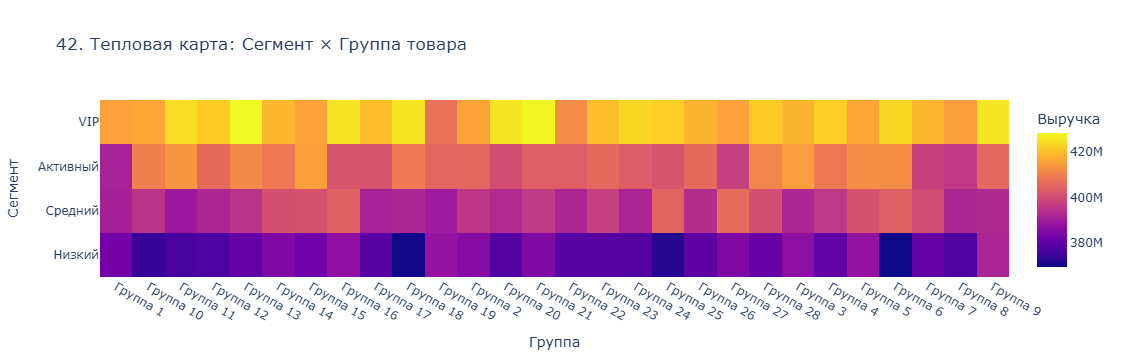

In [58]:
# График 42: Heatmap сегмент × группа
heatmap_sg = seg_group_rev.pivot(index='Сегмент', columns='Группа', values='Сумма в чеке')
heatmap_sg = heatmap_sg.reindex(segment_order)

fig42 = px.imshow(heatmap_sg, aspect='auto',
                  title='42. Тепловая карта: Сегмент × Группа товара',
                  labels=dict(color='Выручка'))
all_figures.append(('42. Heatmap Сегмент-Группа', fig42))
fig42.show()

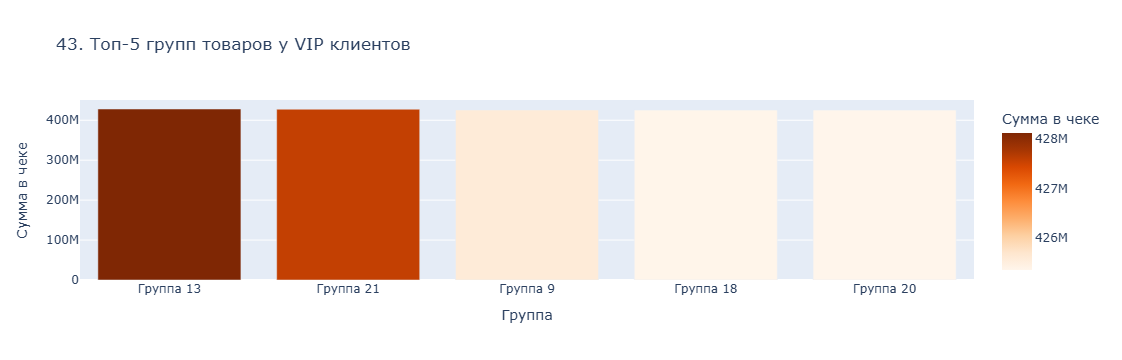

In [59]:
# График 43: Топ-5 групп для VIP
vip_groups = df_seg_group[df_seg_group['Сегмент'] == 'VIP'].groupby('Группа')['Сумма в чеке'].sum().nlargest(5).reset_index()

fig43 = px.bar(vip_groups, x='Группа', y='Сумма в чеке',
               title='43. Топ-5 групп товаров у VIP клиентов',
               color='Сумма в чеке', color_continuous_scale='Oranges')
all_figures.append(('43. Топ-5 для VIP', fig43))
fig43.show()

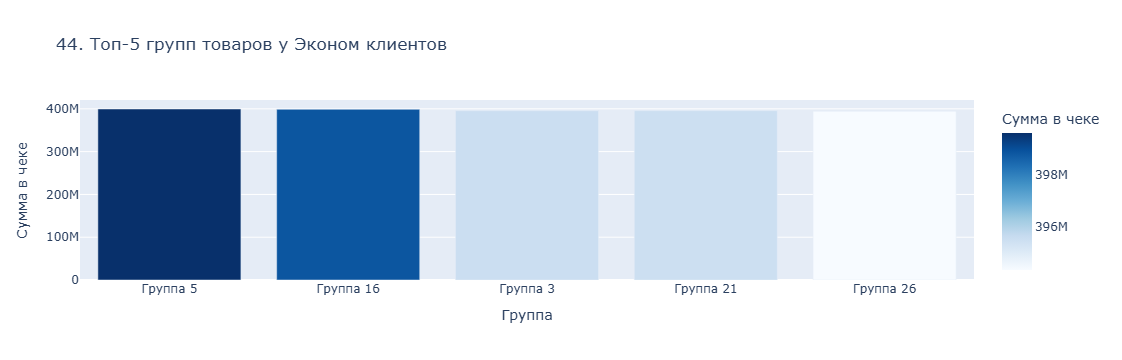

In [60]:
# График 44: Топ-5 групп для Эконом
econ_groups = df_seg_group[df_seg_group['Ценовой сегмент'] == 'Эконом'].groupby('Группа')['Сумма в чеке'].sum().nlargest(5).reset_index()

fig44 = px.bar(econ_groups, x='Группа', y='Сумма в чеке',
               title='44. Топ-5 групп товаров у Эконом клиентов',
               color='Сумма в чеке', color_continuous_scale='Blues')
all_figures.append(('44. Топ-5 для Эконом', fig44))
fig44.show()

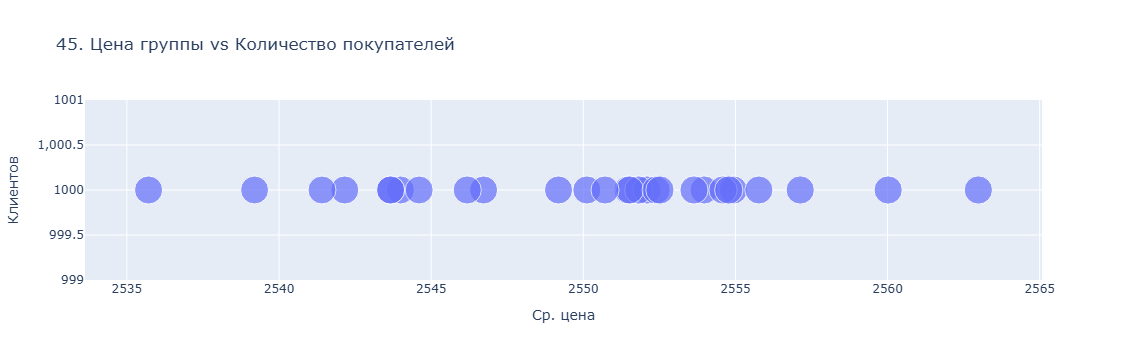

In [61]:
# График 45: Scatter - цена группы vs количество покупателей
group_clients = df_long.groupby('Группа').agg({
    'client_id': 'nunique',
    'Средняя цена товара': 'mean',
    'Сумма в чеке': 'sum'
}).reset_index()
group_clients.columns = ['Группа', 'Клиентов', 'Ср. цена', 'Выручка']

fig45 = px.scatter(group_clients, x='Ср. цена', y='Клиентов', size='Выручка',
                   hover_name='Группа',
                   title='45. Цена группы vs Количество покупателей')
all_figures.append(('45. Цена vs Клиенты', fig45))
fig45.show()

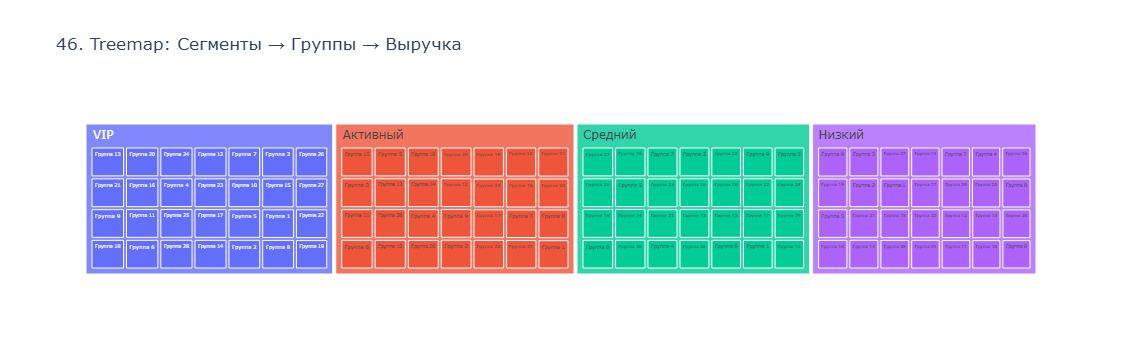

In [62]:
# График 46: Treemap
treemap_data = df_seg_group.groupby(['Сегмент', 'Группа'])['Сумма в чеке'].sum().reset_index()

fig46 = px.treemap(treemap_data, path=['Сегмент', 'Группа'], values='Сумма в чеке',
                   title='46. Treemap: Сегменты → Группы → Выручка')
all_figures.append(('46. Treemap', fig46))
fig46.show()

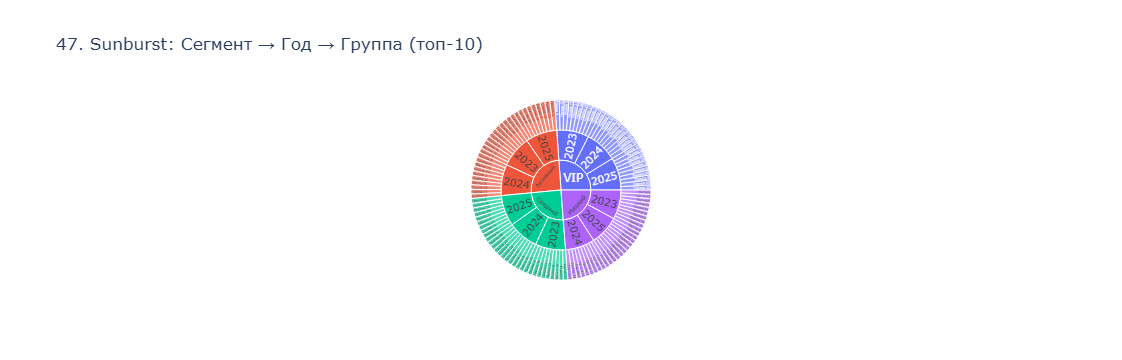

In [63]:
# График 47: Sunburst
sunburst_data = df_seg_group.groupby(['Сегмент', 'Год', 'Группа'])['Сумма в чеке'].sum().reset_index()
# Берём только топ-10 групп для читаемости
top10_groups = group_stats.nlargest(10, 'Выручка')['Группа'].tolist()
sunburst_data = sunburst_data[sunburst_data['Группа'].isin(top10_groups)]

fig47 = px.sunburst(sunburst_data, path=['Сегмент', 'Год', 'Группа'], values='Сумма в чеке',
                    title='47. Sunburst: Сегмент → Год → Группа (топ-10)')
all_figures.append(('47. Sunburst', fig47))
fig47.show()

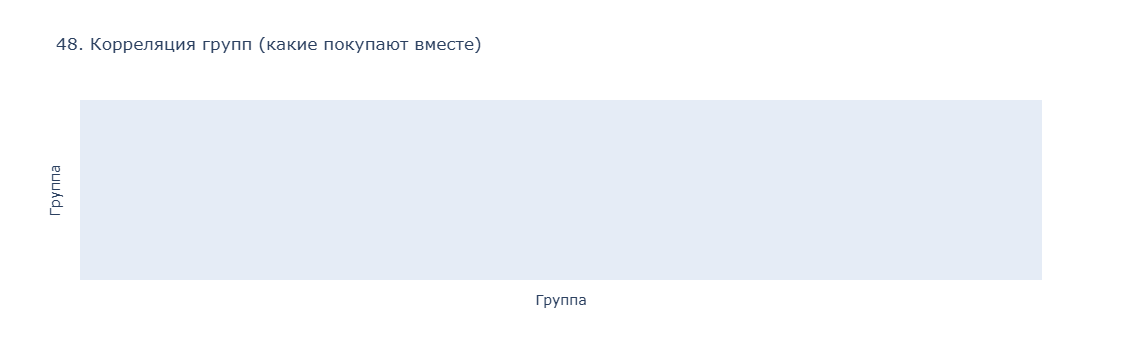

In [64]:
# График 48: Корреляция между группами (какие покупают вместе)
# Создаём матрицу клиент x группа
client_group = df_long.groupby(['client_id', 'Группа'])['Сумма в чеке'].sum().unstack(fill_value=0)
# Бинаризуем (покупал/не покупал)
client_group_binary = (client_group > 0).astype(int)
# Корреляция
corr_matrix = client_group_binary.corr()

fig48 = px.imshow(corr_matrix, aspect='auto',
                  title='48. Корреляция групп (какие покупают вместе)',
                  color_continuous_scale='RdBu_r')
all_figures.append(('48. Корреляция групп', fig48))
fig48.show()

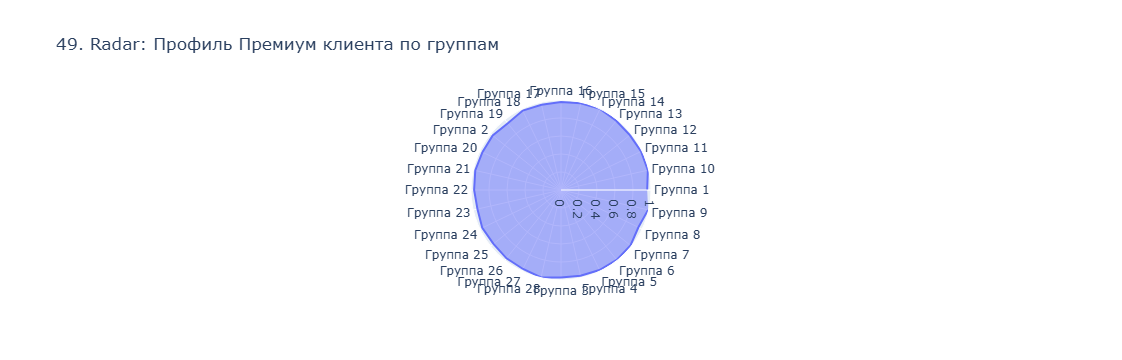

In [65]:
# График 49: Radar профиль Премиум клиента
premium_profile = df_seg_group[df_seg_group['Ценовой сегмент'] == 'Премиум'].groupby('Группа')['Сумма в чеке'].sum()
premium_profile = premium_profile / premium_profile.max()  # Нормализация

fig49 = go.Figure()
fig49.add_trace(go.Scatterpolar(
    r=premium_profile.values,
    theta=premium_profile.index,
    fill='toself',
    name='Премиум'
))
fig49.update_layout(title='49. Radar: Профиль Премиум клиента по группам')
all_figures.append(('49. Radar Премиум', fig49))
fig49.show()

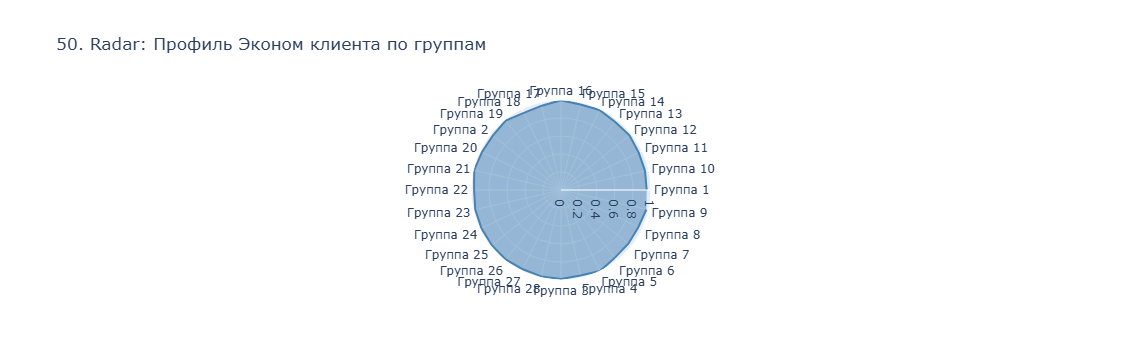

In [66]:
# График 50: Radar профиль Эконом клиента
economy_profile = df_seg_group[df_seg_group['Ценовой сегмент'] == 'Эконом'].groupby('Группа')['Сумма в чеке'].sum()
economy_profile = economy_profile / economy_profile.max()  # Нормализация

fig50 = go.Figure()
fig50.add_trace(go.Scatterpolar(
    r=economy_profile.values,
    theta=economy_profile.index,
    fill='toself',
    name='Эконом',
    marker_color='steelblue'
))
fig50.update_layout(title='50. Radar: Профиль Эконом клиента по группам')
all_figures.append(('50. Radar Эконом', fig50))
fig50.show()

In [67]:
print(f'\n=== ИТОГО: {len(all_figures)} графиков ===')
for i, (name, _) in enumerate(all_figures, 1):
    print(f'{i}. {name}')


=== ИТОГО: 52 графиков ===
1. 1. KPI
2. 2. Выручка по годам
3. 3. Клиенты по годам
4. 4. Доля выручки
5. 5. Тепловая карта Год-Месяц
6. 6. Сегменты клиентов
7. 7. Выручка по сегментам
8. 8. Динамика сегментов
9. 9. Топ-20 по выручке
10. 10. Топ-20 по частоте
11. 11. Ценовые сегменты
12. 12. Цена vs Частота
13. 13. Box plot цен
14. 14. Выручка ценовых сегментов
15. 15. Премиум vs Эконом
16. 14. Выручка ценовых сегментов
17. 15. Премиум vs Эконом
18. 16. Миграция 2023-2024
19. 17. Миграция 2024-2025
20. 18. Отток по сегментам
21. 19. Приток по сегментам
22. 20. Sankey миграция
23. 21. Распределение по сумме
24. 22. Распределение по чекам
25. 23. Распределение по ср. чеку
26. 24. Активность по месяцам
27. 25. Сезонность активности
28. 26. Выручка по группам (dropdown)
29. 27. Количество по группам
30. 28. Чеков по группам
31. 29. Ср. цена по группам
32. 30. Топ и Анти-топ
33. 31. Динамика групп
34. 32. Рост 2023-2025
35. 33. Топ-5 по месяцам
36. 34. Тепловая Месяц-Группа
37. 35. Тепловая

---
# РАЗДЕЛ 5: Экспорт в standalone HTML

In [68]:
# Создание HTML отчёта
html_content = '''
<!DOCTYPE html>
<html lang="ru">
<head>
    <meta charset="utf-8">
    <title>Полный отчёт по продажам</title>
    <style>
        * { box-sizing: border-box; }
        body { 
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, sans-serif; 
            margin: 0; padding: 20px; background: #f5f5f5;
        }
        .container { max-width: 1400px; margin: 0 auto; }
        h1 { color: #333; text-align: center; padding: 20px; background: white; border-radius: 10px; margin-bottom: 20px; }
        h2 { color: #444; border-bottom: 3px solid #007bff; padding-bottom: 10px; margin-top: 40px; }
        h3 { color: #666; }
        .chart { background: white; padding: 15px; border-radius: 10px; margin-bottom: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
        .summary { background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px; border-radius: 10px; margin-bottom: 30px; }
        .summary h3 { color: white; margin-top: 0; }
        .summary ul { list-style: none; padding: 0; }
        .summary li { padding: 5px 0; }
        .nav { position: sticky; top: 0; background: white; padding: 15px; border-radius: 10px; margin-bottom: 20px; z-index: 100; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }
        .nav a { margin-right: 15px; color: #007bff; text-decoration: none; }
        .nav a:hover { text-decoration: underline; }
        .grid { display: grid; grid-template-columns: repeat(auto-fit, minmax(600px, 1fr)); gap: 20px; }
        @media (max-width: 768px) { .grid { grid-template-columns: 1fr; } }
    </style>
</head>
<body>
    <div class="container">
        <h1>Полный интерактивный отчёт по продажам</h1>
        
        <div class="nav">
            <strong>Навигация:</strong>
            <a href="#section1">1. Общая статистика</a>
            <a href="#section2">2. Покупатели</a>
            <a href="#section3">3. Группы товаров</a>
            <a href="#section4">4. Связь</a>
        </div>
        
        <div class="summary">
            <h3>Ключевые показатели</h3>
            <ul>
                <li>📊 Всего графиков: ''' + str(len(all_figures)) + '''</li>
                <li>👥 Клиентов: ''' + str(total_clients) + '''</li>
                <li>💰 Общая выручка: ₽''' + f'{total_revenue:,.0f}' + '''</li>
                <li>🛒 Средний чек: ₽''' + f'{avg_check:,.0f}' + '''</li>
                <li>📅 Период: 2023-2025</li>
            </ul>
        </div>
'''

# Разделы
sections = [
    (0, 5, 'section1', '1. Общая статистика'),
    (5, 25, 'section2', '2. Анализ покупателей'),
    (25, 40, 'section3', '3. Анализ групп товаров'),
    (40, 50, 'section4', '4. Связь покупателей и групп')
]

current_section = 0
for i, (name, fig) in enumerate(all_figures):
    # Проверяем, нужно ли начать новый раздел
    if current_section < len(sections) and i == sections[current_section][0]:
        sec_id = sections[current_section][2]
        sec_title = sections[current_section][3]
        html_content += f'\n<h2 id="{sec_id}">{sec_title}</h2>\n<div class="grid">\n'
        current_section += 1
    
    # Добавляем график
    include_js = 'cdn' if i == 0 else False
    html_content += f'<div class="chart">{pio.to_html(fig, full_html=False, include_plotlyjs=include_js)}</div>\n'
    
    # Закрываем grid перед следующим разделом
    if current_section < len(sections) and i == sections[current_section][0] - 1:
        html_content += '</div>\n'

html_content += '''
        </div>
    </div>
</body>
</html>
'''

# Сохраняем
output_file = 'full_sales_report.html'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f'✅ Отчёт сохранён: {output_file}')
print(f'📊 Всего графиков: {len(all_figures)}')

✅ Отчёт сохранён: full_sales_report.html
📊 Всего графиков: 52
